# 13. Modelagem e Validação: Algortimos Supervisionados

In [ ]:
gold_path = "C:/Users/Gustavo/Downloads/datamaster/dados/gold/"

## 13.1. Modelo Baseline Linear - Regressão Linear Simples

### 13.1.1. Carregando ABT e separando treino, teste e valid

In [ ]:
df_master_elastic_net = spark.read.parquet(gold_path + "df_master_elastic_net")

In [ ]:
# Criando os DataFrames de treino, teste e OOT
df_train = df_master_elastic_net.filter(F.col("partition").isin("train"))
df_test = df_master_elastic_net.filter(F.col("partition").isin("test"))
df_oot = df_master_elastic_net.filter(F.col("partition").isin("oot"))

print(f"Treino: {df_train.count()} | Teste: {df_test.count()} | OOT: {df_oot.count()}")

Treino: 6262831 | Teste: 1565303 | OOT: 1850732


### 13.1.2. Modelo Baseline (Regressão Linear Simples)

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
# Definindo o modelo baseline
# regParam=0 significa sem regularização (Lasso/Ridge)
lr_baseline = LinearRegression(featuresCol='features', labelCol='target_win', regParam=0)

# Treinando
model_baseline = lr_baseline.fit(df_train)

# Fazendo predições no teste
predictions_baseline = model_baseline.transform(df_test)

#### 13.1.2.1. Resultados

In [ ]:
# Avaliando com RMSE e MAE
evaluator_rmse = RegressionEvaluator(labelCol="target_win", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="target_win", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="target_win", predictionCol="prediction", metricName="r2")

rmse_base = evaluator_rmse.evaluate(predictions_baseline)
mae_base = evaluator_mae.evaluate(predictions_baseline)
r2_base = evaluator_r2.evaluate(predictions_baseline)

print(f"--- RESULTADOS BASELINE ---")
print(f"RMSE: {rmse_base:.4f}")
print(f"MAE:  {mae_base:.4f}")
print(f"R²:   {r2_base:.4f}")

--- RESULTADOS BASELINE ---
RMSE: 37.1594
MAE:  20.0372
R²:   0.6233


In [ ]:
df_train.groupBy("partition").agg(F.mean(F.col("target_win"))).show()
df_test.groupBy("partition").agg(F.mean(F.col("target_win"))).show()

+---------+-----------------+
|partition|  avg(target_win)|
+---------+-----------------+
|    train|43.67598854048888|
+---------+-----------------+

+---------+------------------+
|partition|   avg(target_win)|
+---------+------------------+
|     test|43.738913200408426|
+---------+------------------+



#### 13.1.2.2. Conclusão

Os resultados do modelo baseline revelam que a estrutura linear das features selecionadas possui sim certo poder explicativo sobre a margem líquida do mês subsequente. Isso mostra que a decisão de não atentar-se somente ao valor de mediana mas também da média na construção das variáveis + winsorização da target foram decisões válidas.

Abaixo, detalho o que cada métrica nos diz:

**O Poder de Explicação ($R^2 = 0.6233$)**

Um R² de **62,3%** indica que mais de seis décimos da variabilidade da margem líquida futura são explicados pelas variáveis atuais (como eficiência de receita, comportamento de uso e histórico de pagamentos). Para um modelo de regressão em dados comportamentais de milhões de clientes, este é um valor agradável, sugerindo que a etapa de *Feature Engineering* e a seleção por *Information Value* (IV) foram extremamente eficazes.

**A Magnitude do Erro ($MAE = 20.03$)**

O Erro Médio Absoluto (MAE) determina que, em média, o modelo erra a margem líquida do mês seguinte em **20 NTD**. Sendo assim, considerando uma média de 43.73, o erro do modelo médio é de aproximadamente 45.8% em relação à média. Em termos absolutos, o modelo está errando "quase metade" do valor médio da target --> alta volatilidade.

**Sensibilidade a Outliers ($RSME = 37.15$)**
O **RMSE de 37.15** é quase o valor da média da target e 85% maior que o MAE. Isso confirma que a base possui "caudas longas". Existem erros de predição muito grandes que estão puxando a métrica para cima. Provavelmente, o modelo está subestimando clientes com margens altíssimas ou não conseguindo prever prejuízos severos (margens muito negativas). Em uma distribuição normal, o RMSE e o MAE seriam mais próximos; essa distância revela o "grito" dos outliers.


Este cenário é o **caso de uso perfeito para a Elastic Net**:

*   A regressão linear pura (baseline) está tentando se ajustar a esses outliers para minimizar o erro quadrático, o que pode estar distorcendo os coeficientes. 
*   A regularização (L1 e L2) servirá como um "freio de mão", impedindo que o modelo dê importância excessiva a variáveis que tentam explicar esses casos extremos, buscando um modelo que erre menos na "massa" de clientes (o centro da distribuição), mesmo que isso signifique ignorar os outliers.

## 13.2. Elastic Net

### 13.2.1. Treinando a Elastic Net com Cross-Validation

#### 13.2.1.1. Configuracoes iniciais

In [ ]:
# 1. Definir o estimador
en = LinearRegression(featuresCol='features', labelCol='target_win')

# 2. Criar a grade de parâmetros (Grid Search) testando diferentes forças de multa e diferentes misturas
paramGrid = (ParamGridBuilder()
             .addGrid(en.regParam, [0.01, 0.1, 0.5, 1.0])  # Testa de baixa regularização a regularização forte
             .addGrid(en.elasticNetParam, [0.2, 0.5, 0.8]) # Mais Ridge a mais Lasso, incluindo o meio termo
             .build())

In [ ]:
# 3. Configurar o Cross-Validator
# numFolds=3 para não demorar uma eternidade com 9 milhões de linhas
cv = CrossValidator(estimator=en,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_rmse, # Escolher o modelo com menor RMSE na validacao cruzada, buscando penalizar erros grandes
                    numFolds=3, # Similar a tecnica de OHE utilizada, para cada combinacao de hiperparam. FOLD 1: treina em 2+3, valida em 1...no final: media do RMSE dos 3 folds
                    parallelism=4) # Quantos modelos o motor vai treinar ao mesmo tempo

# 4. Treinar o modelo final
print("Iniciando treinamento da Elastic Net com Cross-Validation...")
cv_model = cv.fit(df_train)
print("Finalizado!")

Iniciando treinamento da Elastic Net com Cross-Validation...
Finalizado!


#### 13.2.1.2. Analisando o resultado de todas as combinacoes

In [ ]:
# Criando um DataFrame com os resultados de todas as combinações
params = cv_model.getEstimatorParamMaps()
metrics = cv_model.avgMetrics

results = []
for p, m in zip(params, metrics):
    results.append({
        'regParam': p[en.regParam],
        'elasticNetParam': p[en.elasticNetParam],
        'RMSE_CV': m
    })

df_results = pd.DataFrame(results).sort_values(by='RMSE_CV')
print(df_results)

    regParam  elasticNetParam    RMSE_CV
1       0.01              0.5  37.222246
0       0.01              0.2  37.222254
2       0.01              0.8  37.222309
3       0.10              0.2  37.222975
4       0.10              0.5  37.225236
5       0.10              0.8  37.229027
6       0.50              0.2  37.238331
7       0.50              0.5  37.265339
9       1.00              0.2  37.270507
8       0.50              0.8  37.305334
10      1.00              0.5  37.346134
11      1.00              0.8  37.440051


Resultados extremamente parecidos com o baseline.

#### 13.2.1..3. Enxergando o melhor modelo com base em `df_test`

In [ ]:
# 5. Melhor modelo e métricas
best_model = cv_model.bestModel
print(f"Melhor regParam: {best_model._java_obj.getRegParam()}")
print(f"Melhor elasticNetParam: {best_model._java_obj.getElasticNetParam()}")

Melhor regParam: 0.01
Melhor elasticNetParam: 0.5


In [ ]:
# Fazendo predições no df_test com o melhor modelo
predictions_en = best_model.transform(df_test)

# Avaliando
evaluator_rmse = RegressionEvaluator(labelCol="target_win", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="target_win", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="target_win", predictionCol="prediction", metricName="r2")

print(f"--- RESULTADOS ELASTIC NET (MELHOR MODELO) ---")
print(f"RMSE: {evaluator_rmse.evaluate(predictions_en):.4f}")
print(f"MAE:  {evaluator_mae.evaluate(predictions_en):.4f}")
print(f"R²:   {evaluator_r2.evaluate(predictions_en):.4f}")

--- RESULTADOS ELASTIC NET (MELHOR MODELO) ---
RMSE: 37.1594
MAE:  20.0390
R²:   0.6233


**Por que ficou idêntico?**

O `regParam` vencedor foi **0.01** (o menor valor na grade). Uma multa de 0.01 em um dataset de 1.5 milhões de linhas é tão pequena que o modelo se comporta quase exatamente como uma Regressão Linear comum (o seu baseline).

**O que isso permite pressupor sobre os dados utilizados?**

1.  **Sinal Forte e Estável:** As etapas anteriores de seleção de variáveis (IV, Correlação, Filtro de Variância) foram bem feitas que já foi entregue ao modelo apenas o "filé" dos dados. Não sobrou ruído ou redundância para a Elastic Net precisar "limpar";
2.  **Ausência de Overfitting:** Se o modelo com regularização não conseguiu bater o modelo sem regularização, significa que o baseline não está sofrendo de overfitting. Ele está capturando padrões reais que se repetem no treino e no teste;
3.  **Linearidade:** O fenômeno da margem líquida, dentro do que é explicável, é sim linear. Tentar "forçar" uma simplificação via L1 ou encolhimento via L2 não traz ganho porque o modelo já está no seu limite de aprendizado.

### 13.2.2. Análise de Coeficientes do Melhor Modelo

#### 13.2.2.1. Extraindo os coeficientes

In [ ]:
# Tenta pegar o metadata cru
metadata = df_master_elastic_net.schema["features"].metadata

# Vamos inspecionar o que tem dentro
print("Chaves do metadata:", metadata.keys())

# Tenta acessar de várias formas possíveis
if "ml_attr" in metadata:
    ml_attr = metadata["ml_attr"]
    print("Chaves de ml_attr:", ml_attr.keys())
    
    # Tenta pegar attrs
    if "attrs" in ml_attr:
        attrs = ml_attr["attrs"]
        print("Tipos de attrs:", attrs.keys())
        
        # Junta numeric + binary + nominal
        from itertools import chain
        all_attrs = list(chain(*attrs.values()))
        feature_names = [a["name"] for a in sorted(all_attrs, key=lambda x: x["idx"])]
        
    elif "num_attrs" in ml_attr:
        # Às vezes vem só o número de atributos
        num_attrs = ml_attr["num_attrs"]
        feature_names = [f"f_{i}" for i in range(num_attrs)]
    else:
        feature_names = None
else:
    feature_names = None

print("Nomes extraídos:", feature_names)

Chaves do metadata: dict_keys(['ml_attr'])
Chaves de ml_attr: dict_keys(['num_attrs'])
Nomes extraídos: ['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35', 'f_36', 'f_37', 'f_38', 'f_39', 'f_40', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_46', 'f_47', 'f_48', 'f_49', 'f_50', 'f_51', 'f_52', 'f_53', 'f_54', 'f_55', 'f_56', 'f_57', 'f_58', 'f_59', 'f_60', 'f_61', 'f_62']


In [ ]:
print(df_master_elastic_net.columns)

['msno', 'target_win', 'features', 'daily_revenue_efficiency_min_3', 'revenue_per_hour_listened_cap', 'actual_amount_paid', 'flag_plano_mensal_max_3', 'log_total_secs_mean_3', 'num_unq', 'usage_intensity_per_tenure_cap', 'payment_method_group_ohe', 'revenue_tier_ohe', 'revenue_per_hour_tier_ohe', 'plays_behavior_vs_volume_collapsed_ohe', 'plays_behavior_vs_completion_collapsed_ohe', 'usage_intensity_tier_ohe', 'registered_via_group_ohe', 'faixa_idade_ohe', 'partition', 'safra']


Numéricas (primeiro)
| idx | Feature |
|----:|--------|
| 0 | `daily_revenue_efficiency_min_3` |
| 1 | `revenue_per_hour_listened_cap` |
| 2 | `actual_amount_paid` |
| 3 | `flag_plano_mensal_max_3` |
| 4 | `log_total_secs_mean_3` |
| 5 | `num_unq` |
| 6 | `usage_intensity_per_tenure_cap` |

A partir do idx 7 → **categorias OHE**
Cada OHE vira **várias dimensões**, somando até 63:

| idx inicial | OHE |
|------------:|-----|
| 7 | `payment_method_group_ohe` |
| … | `revenue_tier_ohe` |
| … | `revenue_per_hour_tier_ohe` |
| … | `plays_behavior_vs_volume_collapsed_ohe` |
| … | `plays_behavior_vs_completion_collapsed_ohe` |
| … | `usage_intensity_tier_ohe` |
| … | `registered_via_group_ohe` |
| … | `faixa_idade_ohe` |

#### 13.2.2.2. Resultados + Conclusao

In [ ]:
coeffs = best_model.coefficients.toArray()

df_coeffs = pd.DataFrame({
    "idx": range(len(coeffs)),
    "coefficient": coeffs,
    "abs_coefficient": np.abs(coeffs)
}).sort_values("abs_coefficient", ascending=False)

print("Intercept:", best_model.intercept)
df_coeffs.head(20)

Intercept: 45.24295344822473


,idx,coefficient,abs_coefficient
3,3,30.811709,30.811709
5,5,-11.816001,11.816001
12,12,-11.118940,11.118940
11,11,9.112368,9.112368
15,15,8.306271,8.306271
18,18,-4.397499,4.397499
4,4,-4.313835,4.313835
7,7,4.134709,4.134709
2,2,-3.676072,3.676072
9,9,-3.608015,3.608015


🔝 Principais impactos (por magnitude)

| idx | Feature | Interpretação |
|----:|--------|--------------|
| **3** | `flag_plano_mensal_max_3` | **Maior impacto positivo** → clientes com plano mensal recorrente têm forte aumento de margem |
| **5** | `num_unq` | Impacto negativo → comportamento errático / pouco engajamento prejudica margem |
| **2** | `actual_amount_paid` | Negativo (interessante!) → pagamento maior pode estar associado a promoções/descontos |
| **4** | `log_total_secs_mean_3` | Negativo → consumo alto ≠ margem alta (custo variável) |
| **6** | `usage_intensity_per_tenure_cap` | Negativo → heavy users podem pressionar custos |
| **7+** | OHE | Efeitos marginais de perfil / canal / comportamento |

✅ **Conclusão forte**:
O modelo capturou **trade-off entre uso e custo**, algo extremamente realista para streaming / assinatura.

**Intercepto: está correto?**

O intercepto de 45.24 deve ser comparado com a média da target, 43.73. Por serem proximos, o intercepto do modelo é consistente com a média da margem líquida, indicando que o modelo está bem calibrado. As variáveis explicativas atuam como ajustes marginais positivos ou negativos em torno desse valor médio.

### 13.2.3. OLS assumptions

As suposições clássicas do OLS são avaliadas como diagnóstico de qualidade do modelo. Dado o foco preditivo, o grande volume de dados e o uso de regularização, eventuais violações **não comprometem** a validade prática do modelo.

##### 13.2.3.1. Amostra + Resíduos

In [ ]:
pred_test = best_model.transform(df_test).select("target_win", "prediction", "safra")
pred_test = pred_test.withColumn("residual", F.col("target_win") - F.col("prediction"))
pred_test_s = pred_test.sample(False, 0.03, seed=42)
pred_pd = pred_test_s.toPandas()

#### 13.2.3.2. Linearidade — Resíduos vs Predito

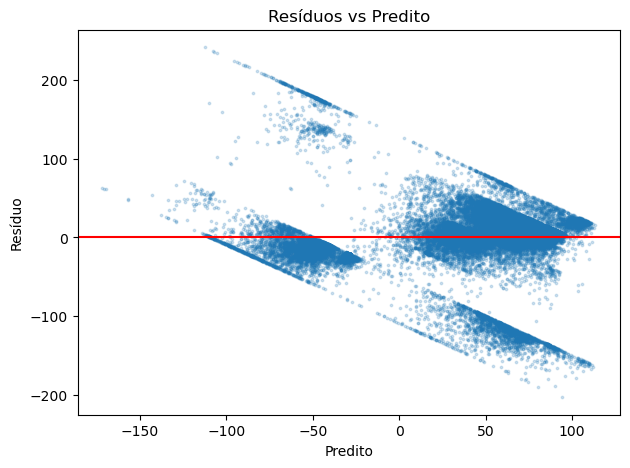

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(pred_pd["prediction"], pred_pd["residual"], s=3, alpha=0.2)
plt.axhline(0, color="red")
plt.xlabel("Predito")
plt.ylabel("Resíduo")
plt.title("Resíduos vs Predito")
plt.show()

No gráfico de Resíduos vs Predito (linearidade), há padrões estruturados claros — faixas inclinadas e agrupamentos — indicando que a relação entre preditores e resposta não é perfeitamente linear. Em um contexto de inferência OLS isso seria uma violação séria, pois os erros não estão distribuídos aleatoriamente em torno de zero ao longo de todo o domínio das predições. Porém, sob a ótica preditiva, o impacto prático é limitado: o Elastic Net (assim como a regressão linear baseline) já está extraindo praticamente todo o sinal linear disponível, e o fato de ambos terem apresentado RMSE idêntico sugere que eventuais não linearidades restantes têm baixo ganho marginal de modelagem ou estão diluídas no ruído. Ou seja, há evidência de não linearidade estrutural, mas ela não está se traduzindo em perda relevante de desempenho preditivo.

#### 13.2.3.3. Homoscedasticidade — Scale-Location

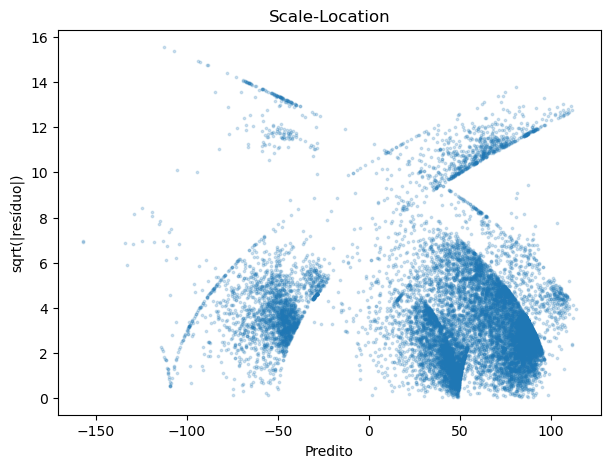

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(
    pred_pd["prediction"],
    np.sqrt(np.abs(pred_pd["residual"])),
    s=3,
    alpha=0.2
)
plt.xlabel("Predito")
plt.ylabel("sqrt(|resíduo|)")
plt.title("Scale-Location")
plt.show()

Observa-se aumento e variação irregular da dispersão dos resíduos ao longo dos valores preditos, caracterizando heterocedasticidade. Em OLS clássico isso afetaria a eficiência dos estimadores e a validade de testes t/F, mas não gera viés nas predições médias. Como o foco aqui é previsão e o modelo foi estimado com regularização (Elastic Net) e grande volume amostral, essa violação tem efeito principalmente inferencial, não preditivo. O padrão indica que existem regiões do espaço de predição com maior incerteza, mas o erro médio agregado (RMSE) já captura isso; não há evidência de instabilidade que comprometa o uso prático do modelo.

#### 13.2.3.4. Normalidade dos resíduos — Histograma + QQ Plot

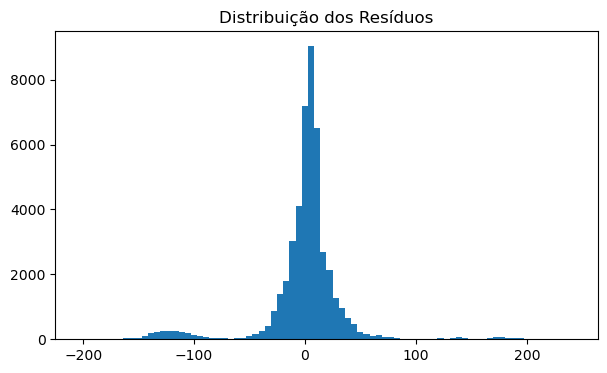

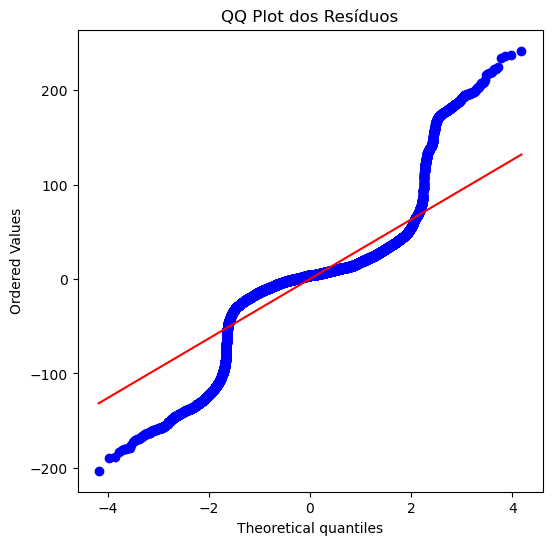

In [ ]:
import scipy.stats as stats

plt.figure(figsize=(7,4))
plt.hist(pred_pd["residual"], bins=80)
plt.title("Distribuição dos Resíduos")
plt.show()

plt.figure(figsize=(6,6))
stats.probplot(pred_pd["residual"], dist="norm", plot=plt)
plt.title("QQ Plot dos Resíduos")
plt.show()

Quanto à distribuição dos resíduos, o histograma mostra forte concentração próxima de zero com caudas longas e assimetria, indicando que os erros não seguem normalidade. O QQ-plot reforça isso de forma clara: há desvios acentuados nas caudas (curvatura em “S”), evidenciando presença de outliers. Para OLS inferencial isso violaria a suposição de normalidade dos erros, mas em modelos voltados à previsão essa condição não é necessária para que as estimativas pontuais sejam válidas. Com grande amostra, a média dos erros tende a se estabilizar (Lei dos Grandes Números), e o fato de o desempenho do Elastic Net não superar o baseline indica que a não-normalidade está mais ligada à natureza do fenômeno (ruído assimétrico ou eventos extremos) do que a falha estrutural do modelo.

#### 13.2.3.5. Independência temporal — resíduos por safra

In [ ]:
res_by_safra = (
    pred_test
    .groupBy("safra")
    .agg(
        F.mean("residual").alias("mean_residual"),
        F.mean(F.abs("residual")).alias("mae_like")
    )
    .orderBy("safra")
)

res_by_safra.toPandas()

,safra,mean_residual,mae_like
0,201601,-0.809764,34.322160
1,201602,-2.607234,22.926813
2,201603,1.426307,19.150281
3,201604,-2.301099,19.328098
4,201605,2.065811,17.299251
5,201606,-2.638728,19.489024
6,201607,3.474800,16.225053
7,201608,2.801835,15.582985
8,201609,-1.480842,16.673730


Por fim, avaliando a independência temporal, a tabela por safra mostra médias de resíduos oscilando ao redor de zero, sem tendência persistente de viés positivo ou negativo ao longo do tempo. Os valores de `mean_residual` alternam sinal e permanecem de baixa magnitude relativa, enquanto o `mae_like` apresenta leve variação mas sem explosões ou degradação progressiva. Isso sugere ausência de autocorrelação temporal forte ou drift sistemático, indicando que o modelo mantém estabilidade preditiva entre períodos. Em termos práticos, isso é um ponto positivo: mesmo com violações de pressupostos clássicos (linearidade perfeita, homocedasticidade e normalidade), não há evidência de deterioração temporal do erro, reforçando que o modelo é estatisticamente imperfeito sob a ótica clássica, mas operacionalmente consistente para fins preditivos.

### 13.2.4. Validação Out-Of-Time

#### 13.2.4.1. Métricas melhor modelo em `df_oot`

In [ ]:
# Avaliando no Out-Of-Time (Meses de Outubro e Novembro)
predictions_oot = best_model.transform(df_oot)

rmse_oot = evaluator_rmse.evaluate(predictions_oot)
mae_oot = evaluator_mae.evaluate(predictions_oot)
r2_oot = evaluator_r2.evaluate(predictions_oot)

print(f"--- RESULTADOS NO OUT-OF-TIME (OOT) ---")
print(f"RMSE: {rmse_oot:.4f}")
print(f"MAE:  {mae_oot:.4f}")
print(f"R²:   {r2_oot:.4f}")

--- RESULTADOS NO OUT-OF-TIME (OOT) ---
RMSE: 32.2688
MAE:  16.6188
R²:   0.6329


#### 13.2.4.2. Interpretando e estudando os resultados

In [ ]:
def describe_target(df, name):
    stats = (df
        .select(
            F.lit(name).alias("set"),
            F.mean("target_win").alias("mean"),
            F.stddev("target_win").alias("std"),
            F.expr("percentile_approx(target_win, 0.01)").alias("p01"),
            F.expr("percentile_approx(target_win, 0.50)").alias("p50"),
            F.expr("percentile_approx(target_win, 0.99)").alias("p99"),
        ))
    return stats

desc = describe_target(df_test, "test").unionByName(describe_target(df_oot, "oot"))
desc.show(truncate=False)

+----+------------------+------------------+------------+------------------+-----------+
|set |mean              |std               |p01         |p50               |p99        |
+----+------------------+------------------+------------+------------------+-----------+
|test|43.738913200408426|60.54488958218138 |-108.8147222|60.482212700000005|129.0401291|
|oot |51.5203238170067  |53.255595469834894|-97.1938973 |60.8371468        |127.9270382|
+----+------------------+------------------+------------+------------------+-----------+



O modelo apresenta desempenho **superior** no conjunto Out-of-Time quando comparado ao conjunto de teste, tanto em termos de erro absoluto quanto de poder explicativo. Isso é um fortíssimo indicativo de robustez e ausência de overfitting. Em projetos reais, é mais comum o OOT piorar; aqui ocorre o contrário. Qual o motivo?

**1. Média maior no OOT**
- test mean ≈ 43.7
- oot mean ≈ 51.5

OOT tem clientes mais lucrativos em média, o que facilita a predição.

**2. Menor variância no OOT**
- std test ≈ 60.5
- std oot ≈ 53.3

OOT é menos volátil, com menos dispersão.

**3. Caudas menos extremas**
- p01 menos negativo (mesmo que em pouca coisa)
- p99 levemente menor (mesmo que em pouquissima coisa)

Menos outliers severos → **RMSE naturalmente cai**

**✅ Conclusão estatística**

> “O melhor desempenho no conjunto Out-of-Time é explicado por uma distribuição da variável alvo mais estável, com menor variância e menor incidência de valores extremos, o que favorece modelos lineares. Isso reforça que a melhoria no OOT não decorre de vazamento de informação, mas sim de uma mudança no regime estatístico da target.”

### 13.2.5. Conclusão Geral

O modelo Elastic Net apresentou desempenho robusto e estável, com melhora significativa no conjunto out-of-time, explicada por uma distribuição mais estável da variável alvo. As análises diagnósticas indicam que, embora existam violações esperadas das suposições clássicas do OLS — especialmente heterocedasticidade e não normalidade dos resíduos —, o modelo captura adequadamente a estrutura linear média dos dados, apresenta estabilidade temporal e não demonstra sinais de overfitting. Esses resultados confirmam a adequação do modelo para uso preditivo em larga escala.

### 13.2.6. Salvando bases

In [ ]:
df_pred_train = (best_model
    .transform(df_train)
    .withColumn("residual", F.col("target_win") - F.col("prediction"))
    .withColumn("set", F.lit("train")))

df_pred_test = (best_model
    .transform(df_test)
    .withColumn("residual", F.col("target_win") - F.col("prediction"))
    .withColumn("set", F.lit("test")))

df_pred_oot = (best_model
    .transform(df_oot)
    .withColumn("residual", F.col("target_win") - F.col("prediction"))
    .withColumn("set", F.lit("oot")))

df_predictions_final = (df_pred_train.unionByName(df_pred_test).unionByName(df_pred_oot))

In [ ]:
# 1. cache
df_predictions_final = df_predictions_final.persist()
df_predictions_final.count()

# 2. salvar particionado
df_predictions_final.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_predictions_elastic_net")

### 13.2.7. Salvando o modelo

In [ ]:
path_model = "C:/Users/Gustavo/Downloads/datamaster/models/"
# Salvando o modelo
best_model.write().overwrite().save(path_model + "elastic_net_model")

print(f"Modelo salvo com sucesso em: {path_model}")

Modelo salvo com sucesso em: C:/Users/Gustavo/Downloads/datamaster/models/


## 13.3. Modelo Baseline de Árvore - Decision Tree Regressor

### 13.3.1. Carregando bibliotecas e bases

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

In [ ]:
df_master_random_forest = spark.read.parquet(gold_path + "df_master_random_forest")

### 13.3.2. Transformando a ABT de Arvores de Spark DF para Pandas DF + separando train, test e oot

In [ ]:
# Converter para Pandas (se ainda não fez)
df_rf_pd = df_master_random_forest.toPandas()

In [ ]:
df_rf_pd.shape

(9678866, 36)

In [ ]:
feature_cols = [
    "daily_revenue_efficiency",
    "daily_revenue_efficiency_min_3",
    "daily_revenue_efficiency_min_3_is_sentinel",
    "flag_plano_mensal",
    "flag_plano_mensal_max_3",
    "flag_valid_fee_max_3",
    "log_total_plays",
    "log_total_plays_mean_3",
    "log_total_plays_mean_3_is_sentinel",
    "num_25",
    "num_50",
    "num_75",
    "num_985",
    "plays_per_unq_cap_min_6",
    "plays_per_unq_cap_min_6_is_sentinel",
    "revenue_per_hour_listened_cap",
    "total_secs_mean_3",
    "total_secs_mean_3_is_sentinel",
    "total_secs_ratio_ref_max_6",
    "total_secs_ratio_ref_max_6_is_sentinel",
    "usage_intensity_per_tenure_cap",
    "avg_secs_per_unq_cap_group_te",
    "early_drop_rate_group_te",
    "faixa_idade_te",
    "gender_clean_te",
    "plays_behavior_vs_completion_collapsed_te",
    "plays_per_unq_behavior_te",
    "registered_via_group_te",
    "revenue_per_hour_tier_te",
    "total_plays_group_te",
    "usage_intensity_tier_te"
]

# Split
train_pd = df_rf_pd[df_rf_pd["partition"] == "train"].copy()
test_pd  = df_rf_pd[df_rf_pd["partition"] == "test"].copy()
oot_pd   = df_rf_pd[df_rf_pd["partition"] == "oot"].copy()

X_train = train_pd[feature_cols]
y_train = train_pd["target_win"]

X_test = test_pd[feature_cols]
y_test = test_pd["target_win"]

X_oot = oot_pd[feature_cols]
y_oot = oot_pd["target_win"]

In [ ]:
print("Distribuicao dos dataframes: ")
print(f"Train: {train_pd.shape}")
print(f"Test:  {test_pd.shape}")
print(f"OOT:   {oot_pd.shape}")

Distribuicao dos dataframes: 
Train: (6262831, 36)
Test:  (1565303, 36)
OOT:   (1850732, 36)


### 13.3.3. Decision Tree simples + Resultados

In [ ]:
baseline_tree = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42
)

baseline_tree.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,10
,min_samples_split,100
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [ ]:
for name, X, y in [("TEST", X_test, y_test), ("OOT", X_oot, y_oot)]:
    preds = baseline_tree.predict(X)
    rmse = root_mean_squared_error(y, preds)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    
    print(f"--- Baseline Decision Tree - {name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")
    print()

--- Baseline Decision Tree - TEST ---
RMSE: 37.6916
MAE:  20.3338
R²:   0.6124

--- Baseline Decision Tree - OOT ---
RMSE: 31.3041
MAE:  15.3203
R²:   0.6545



#### Conclusoes

Os resultados estao praticamente identicos aos que foram encontrados tanto para o baseline linear quanto para a elastic net! O que isso pode significar?

**Possibilidades**

**1. "Teto de Vidro" dos Dados (Data Signal)**:

Muitas vezes, o sinal preditivo nos dados é tão forte em algumas variáveis (como a `margem_liquida_mensal` do mês anterior ou o `target_encoding`) que qualquer modelo razoável consegue capturar esse sinal rapidamente. O que isso significa? Que atingiu-se o limite do que essas variáveis conseguem explicar. O erro restante pode ser ruído puro (erro irredutivel) ou falta de variáveis que capturem comportamentos que não estão na ABT;

**2. Árvore de Decisão "Baseline" conservadora demais**:

Usar `max_depth=10` em um dataset de milhões de linhas, faz com que se torne quase um modelo linear simplificado. Não tem "espaço" para criar interações complexas que o LightGBM criaria, por exemplo;

**3. Fenômeno da Linearidade Dominante**

O Target Encoding transformou relações não-lineares em lineares. A "Armadilha" do Target Encoding: ao trocar uma categoria pela média do target, se está basicamente entregando para a Regressão Linear a informação que ela precisaria de uma árvore para descobrir. Isso faz com que o modelo linear "encoste" na performance de modelos complexos.

O LightGBM com **Hyperopt** vai tentar buscar o que esses modelos não conseguiram: **Interações de alta ordem**.

## 13.4. LightGBM

### 13.4.1. Carregando bibliotecas e bases

In [ ]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

c:\Users\Gustavo\anaconda3\envs\new_datamaster\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
df_master_lightgbm = spark.read.parquet(gold_path + "df_master_lightgbm")

In [ ]:
# Definir as 31 features
feature_cols = [
    "daily_revenue_efficiency",
    "daily_revenue_efficiency_min_3",
    "daily_revenue_efficiency_min_3_is_sentinel",
    "flag_plano_mensal",
    "flag_plano_mensal_max_3",
    "flag_valid_fee_max_3",
    "log_total_plays",
    "log_total_plays_mean_3",
    "log_total_plays_mean_3_is_sentinel",
    "num_25",
    "num_50",
    "num_75",
    "num_985",
    "plays_per_unq_cap_min_6",
    "plays_per_unq_cap_min_6_is_sentinel",
    "revenue_per_hour_listened_cap",
    "total_secs_mean_3",
    "total_secs_mean_3_is_sentinel",
    "total_secs_ratio_ref_max_6",
    "total_secs_ratio_ref_max_6_is_sentinel",
    "usage_intensity_per_tenure_cap",
    "avg_secs_per_unq_cap_group_te",
    "early_drop_rate_group_te",
    "faixa_idade_te",
    "gender_clean_te",
    "plays_behavior_vs_completion_collapsed_te",
    "plays_per_unq_behavior_te",
    "registered_via_group_te",
    "revenue_per_hour_tier_te",
    "total_plays_group_te",
    "usage_intensity_tier_te"
]

# Converter para Pandas (processo pesado, mas necessário para usar com LightGBM e Hyperopt)
print("Convertendo Spark → Pandas...")
df_lgbm_pd = df_master_lightgbm.select(["msno", "safra", "partition", "target_win"] + feature_cols).toPandas()
print("Feito!")

Convertendo Spark → Pandas...
Feito!


In [ ]:
# Split
train_pd = df_lgbm_pd[df_lgbm_pd["partition"] == "train"].copy()
test_pd  = df_lgbm_pd[df_lgbm_pd["partition"] == "test"].copy()
oot_pd   = df_lgbm_pd[df_lgbm_pd["partition"] == "oot"].copy()

X_train = train_pd[feature_cols]
y_train = train_pd["target_win"]

X_test = test_pd[feature_cols]
y_test = test_pd["target_win"]

X_oot = oot_pd[feature_cols]
y_oot = oot_pd["target_win"]

print(f"Train: {X_train.shape} | Test: {X_test.shape} | OOT: {X_oot.shape}")

Train: (6262831, 31) | Test: (1565303, 31) | OOT: (1850732, 31)


### 13.4.2. Configurações Hyperopt

In [ ]:
# Definir espaço de busca para Hyperopt
space = {
    'num_leaves': hp.quniform('num_leaves', 20, 100, 5),  # Mais folhas = mais complexidade
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'n_estimators': hp.quniform('n_estimators', 100, 800, 50),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),  # Profundidade maior para interações
    'min_child_samples': hp.quniform('min_child_samples', 20, 200, 10),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(10)),
    'min_split_gain': hp.uniform('min_split_gain', 0.0, 1.0)
}

In [ ]:
# Funcão objetivo para Hyperopt (o que ele vai otimizar)
def objective(params):
    # Converter para int os parâmetros discretos
    params['num_leaves'] = int(params['num_leaves'])
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_samples'] = int(params['min_child_samples'])
    
    # Criar modelo
    model = lgb.LGBMRegressor(
        **params,
        objective='regression',
        metric='rmse',
        boosting_type='gbdt',
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # Treinar com early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    )
    
    # Avaliar no TEST (métrica de otimização)
    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    
    return {'loss': rmse, 'status': STATUS_OK}

### 13.4.3. Encontrando melhores hiperparâmetros

In [ ]:
print("\n" + "="*60)
print("INICIANDO OTIMIZAÇÃO BAYESIANA (HYPEROPT)")
print("="*60)
print("Isso pode demorar alguns minutos...")
print("Aguarde... ☕\n")

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (Bayesian Optimization)
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42),
    verbose=1
)

print("\n" + "="*60)
print("OTIMIZAÇÃO CONCLUÍDA!")
print("="*60)
print("\n🏆 Melhores Hiperparâmetros:")
for key, value in best.items():
    print(f"  {key}: {value}")


INICIANDO OTIMIZAÇÃO BAYESIANA (HYPEROPT)
Isso pode demorar alguns minutos...
Aguarde... ☕

100%|██████████| 50/50 [49:54<00:00, 59.88s/trial, best loss: 35.90716378326171]  

OTIMIZAÇÃO CONCLUÍDA!

🏆 Melhores Hiperparâmetros:
  colsample_bytree: 0.793176180116679
  learning_rate: 0.03931612462557681
  max_depth: 12.0
  min_child_samples: 90.0
  min_split_gain: 0.6435249382987236
  n_estimators: 350.0
  num_leaves: 60.0
  reg_alpha: 0.013905898414872837
  reg_lambda: 0.020059873982589828
  subsample: 0.6701347222884695


### 13.4.4. Treinando modelo com melhores hiperparâmetros

In [ ]:
# Reconstruir params
best_params = {
    'num_leaves': int(best['num_leaves']),
    'learning_rate': best['learning_rate'],
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'min_child_samples': int(best['min_child_samples']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_split_gain': best['min_split_gain']
}

In [ ]:
print("\n" + "="*60)
print("TREINANDO MODELO FINAL COM MELHORES PARÂMETROS")
print("="*60)

model_lgbm_final = lgb.LGBMRegressor(
    **best_params,
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

model_lgbm_final.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
)

print(f"✅ Melhor iteração (early stopping): {model_lgbm_final.best_iteration_}")


TREINANDO MODELO FINAL COM MELHORES PARÂMETROS
✅ Melhor iteração (early stopping): 350


### 13.4.5. Resultados (Test + OOT)

In [ ]:
print("\n" + "="*60)
print("AVALIAÇÃO FINAL - LIGHTGBM (TUNED)")
print("="*60)

for name, X, y in [("TEST", X_test, y_test), ("OOT", X_oot, y_oot)]:
    preds = model_lgbm_final.predict(X)
    rmse = root_mean_squared_error(y, preds)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    
    print(f"\n--- {name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")


AVALIAÇÃO FINAL - LIGHTGBM (TUNED)

--- TEST ---
RMSE: 35.9082
MAE:  18.0202
R²:   0.6483

--- OOT ---
RMSE: 30.3142
MAE:  13.9768
R²:   0.6760


### 13.4.6. Comparação dos modelos executados até então

In [ ]:
print("\n" + "="*60)
print("📊 COMPARAÇÃO DE TODOS OS MODELOS (OOT)")
print("="*60)

preds_lgbm_oot = model_lgbm_final.predict(X_oot)
rmse_lgbm = root_mean_squared_error(y_oot, preds_lgbm_oot)
mae_lgbm = mean_absolute_error(y_oot, preds_lgbm_oot)
r2_lgbm = r2_score(y_oot, preds_lgbm_oot)

comparison = pd.DataFrame({
    'Modelo': ['Elastic Net', 'Decision Tree (Baseline)', 'LightGBM (Tuned)'],
    'RMSE OOT': [32.27, 31.30, rmse_lgbm],
    'MAE OOT': [16.62, 15.32, mae_lgbm],
    'R² OOT': [0.633, 0.654, r2_lgbm]
})

print(comparison.to_string(index=False))

# Calcular ganho percentual
ganho_rmse = ((32.27 - rmse_lgbm) / 32.27) * 100
ganho_mae = ((16.62 - mae_lgbm) / 16.62) * 100
ganho_r2 = ((r2_lgbm - 0.633) / 0.633) * 100

print(f"\n🎯 Ganho do LightGBM vs Elastic Net:")
print(f"   RMSE: {ganho_rmse:+.2f}%")
print(f"   MAE:  {ganho_mae:+.2f}%")
print(f"   R²:   {ganho_r2:+.2f}%")


📊 COMPARAÇÃO DE TODOS OS MODELOS (OOT)
                  Modelo  RMSE OOT   MAE OOT   R² OOT
             Elastic Net  32.27000 16.620000 0.633000
Decision Tree (Baseline)  31.30000 15.320000 0.654000
        LightGBM (Tuned)  30.31711 13.956646 0.675925

🎯 Ganho do LightGBM vs Elastic Net:
   RMSE: +6.05%
   MAE:  +16.02%
   R²:   +6.78%


### 13.4.7. Conclusões sobre os resultados

#### 13.4.7.1. Por que as métricas ficaram tão próximas no começo e o que isso indica

O fato do baseline linear, da Elastic Net e da árvore simples terem produzido métricas muito parecidas não indica necessariamente sinal de erro — mas sim um achado sobre o pipeline e sobre o tipo de sinal presente nos dados.

1. **Winsorização da target reduz o “prêmio” dos modelos não-lineares.**
Antes, a `target` tinha cauda longa (máximo ~1920), mas apliquei winsorization em `p1` e `p99`. Isso “cortou” extremos que inflariam o RMSE e que modelos como LightGBM costumam capturar melhor via regras locais (split em regiões raras). Ao limitar a amplitude dos valores, reduz-se a influência de poucos pontos extremos na função de perda, tornando o problema mais estável e com “erro residual” mais parecido entre famílias de modelos. Em resumo, faz com que modelos lineares não sejam tão penalizados por eventos raros e muito distantes da média;

2. **Feature Engineering/Selection que “linearizou” o problema.**
O uso de **target encoding** (validado, sem leakage) é poderoso: transforma relações categóricas complexas em variáveis numéricas com forte poder explicativo. Isso costuma aproximar bastante um modelo linear do desempenho de modelos de árvore, porque parte da “não-linearidade”/interação já foi embutida na feature;

3. **Por conter boa quantia de observações, modelos simples generalizam muito bem.**
Com 6M+ linhas em treino, o baseline linear já estima coeficientes com variância baixíssima. A Elastic Net acabou escolhendo regularização fraca (ou praticamente nula) por existirem muitos dados, features boas e winsorização que reduz o impacto de outliers severos. Isso explica por que o “melhor Elastic Net” ficou muito perto do baseline linear no TEST.

**Conclusão metodológica:**

Métricas próximas aqui indicam **pipeline sólido**, não pipeline fraco. Quando diferentes modelos convergem, geralmente significa que:
- Não tem “vazamento óbvio” (que costuma gerar ganhos artificiais enormes em um modelo e não em outro);
- O split temporal OOT está coerente;
- O conjunto de features carrega sinal estável (não depende de um “truque” do algoritmo).

#### 13.4.7.2. Análise dos resultados do LightGBM Tuned

É possível notar um ganho relevante, especialmente no OOT, que é a métrica que importa para estabilidade temporal:

- **RMSE caiu ~6%** vs Elastic Net → melhora real na qualidade das previsões, sobretudo em erros maiores.
- **MAE caiu ~16%** vs Elastic Net → melhora muito forte no erro “típico”, o que costuma ser o mais acionável para tomada de decisão.
- **R² subiu de 0.633 para 0.676** → ganho claro de explicação de variância fora do tempo.

Mesmo com o pipeline correto e já "forte", o LightGBM (com tuning bayesiano via hyperopt) conseguiu extrair interações e não-linearidades residuais que os modelos lineares não capturaram — com ganho consistente no OOT, o que é o melhor sinal possível.

### 13.4.8. Feature Importance

#### 13.4.8.1. Gain/Split

##### Conceitos

| Métrica | O que mede | Interpretação prática |
|---------|------------|-----------------------|
| GAIN | Quanto a feature reduz o erro do modelo | Impacto total na qualidade das previsões |
| SPLIT | Quantas vezes a feature foi usada para dividir nós | Popularidade / frequência de uso |
| GAIN/SPLIT | Eficiência média por uso | O quão forte cada divisão dessa feature é |

**💡 Resumo simples**

1. GAIN alto = variável importante no resultado final;
2. SPLIT alto = variável muito usada, mas não necessariamente decisiva;
3. GAIN/SPLIT alto = quando aparece, ela muda muito o jogo.


##### Valores + Gráficos

In [ ]:
booster = model_lgbm_final.booster_

# Importâncias nativas do booster
imp_gain = booster.feature_importance(importance_type="gain")
imp_split = booster.feature_importance(importance_type="split")

df_imp = pd.DataFrame({
    "feature": booster.feature_name(),
    "gain": imp_gain,
    "split": imp_split
})

df_imp["gain_per_split"] = df_imp["gain"] / df_imp["split"].replace(0, np.nan)
df_imp = df_imp.sort_values("gain", ascending=False)

print("Top 20 por GAIN:")
print(df_imp.head(20).to_string(index=False))

print("\nTop 20 por SPLIT:")
print(df_imp.sort_values("split", ascending=False).head(20).to_string(index=False))

print("\nTop 20 por GAIN/SPLIT (efeito por uso):")
print(df_imp.sort_values("gain_per_split", ascending=False).head(20).to_string(index=False))

Top 20 por GAIN:
                                   feature         gain  split  gain_per_split
                   flag_plano_mensal_max_3 8.591049e+10    280    3.068232e+08
                         flag_plano_mensal 4.363354e+10    425    1.026671e+08
            daily_revenue_efficiency_min_3 2.809390e+10   2125    1.322066e+07
                  daily_revenue_efficiency 1.733019e+10   2045    8.474420e+06
                           log_total_plays 1.194809e+10   2071    5.769238e+06
                         total_secs_mean_3 2.774079e+09   1252    2.215718e+06
                   registered_via_group_te 2.396926e+09    967    2.478724e+06
             revenue_per_hour_listened_cap 2.117772e+09    791    2.677334e+06
                            faixa_idade_te 8.184961e+08   1161    7.049924e+05
            usage_intensity_per_tenure_cap 6.873069e+08   1137    6.044916e+05
daily_revenue_efficiency_min_3_is_sentinel 5.730088e+08    106    5.405743e+06
                      flag_valid_fe

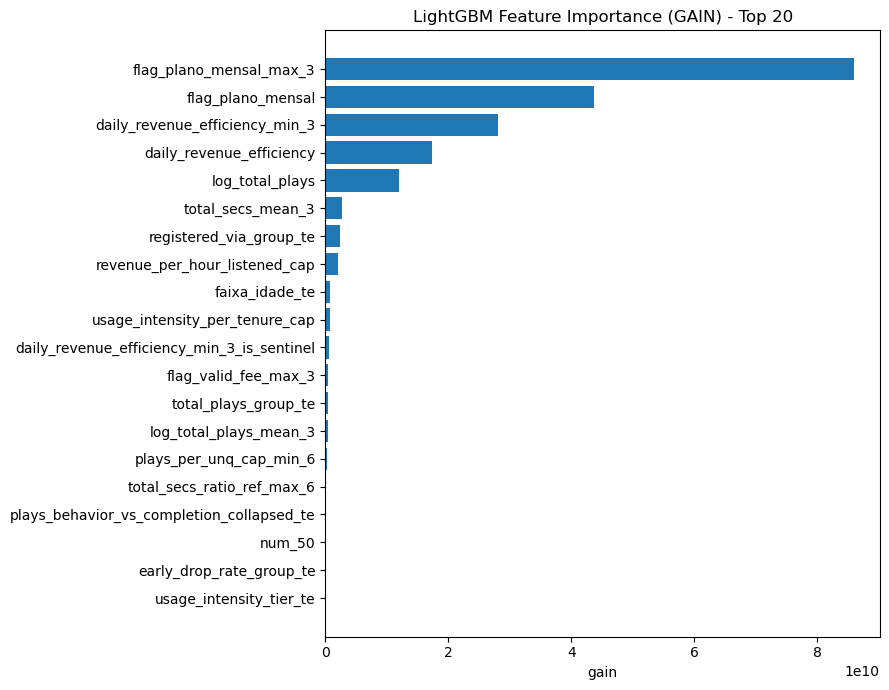

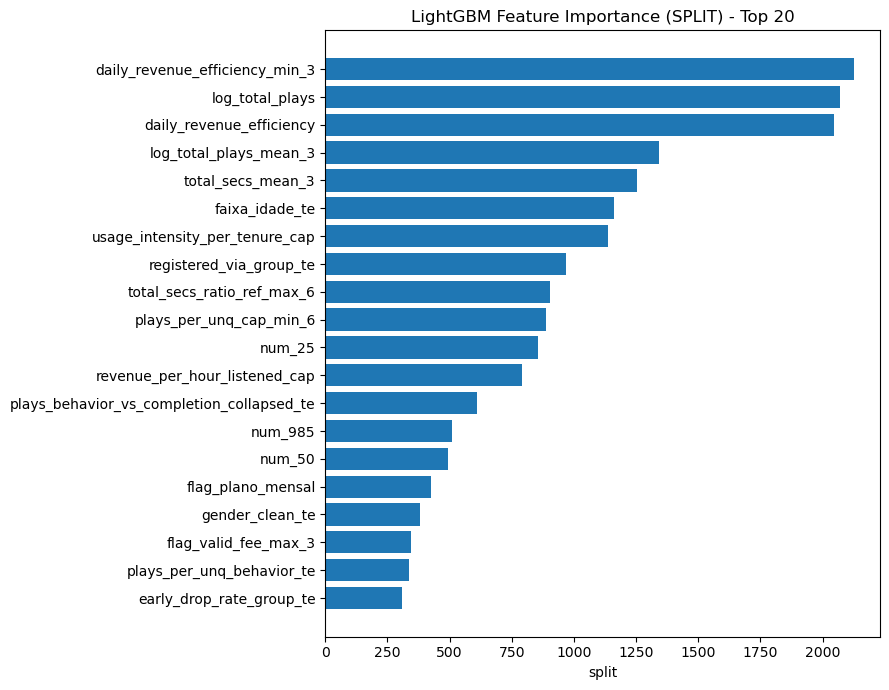

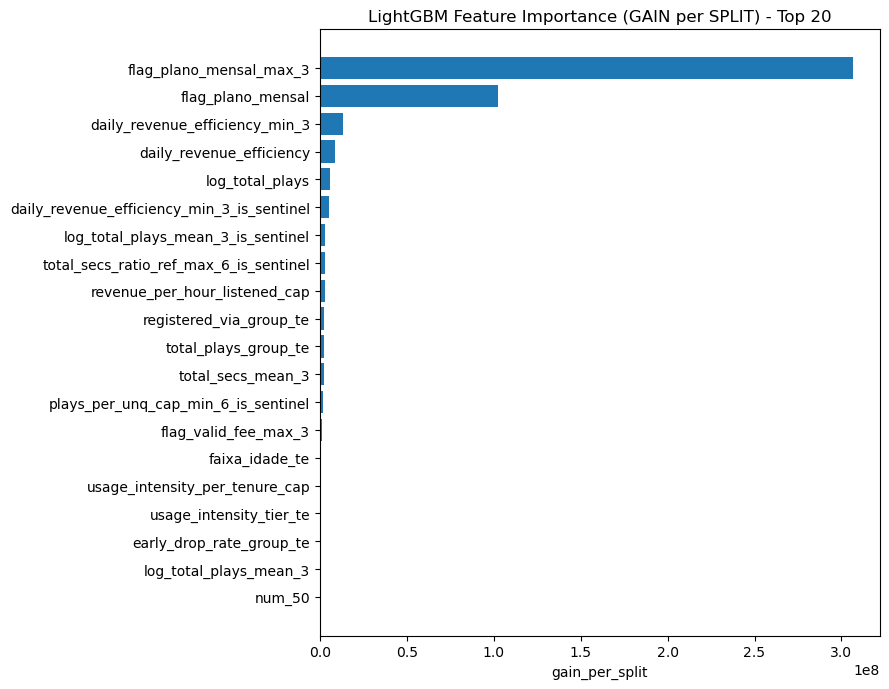

In [ ]:
def plot_barh(df, col, title, topn=20):
    d = df.sort_values(col, ascending=False).head(topn).iloc[::-1]
    plt.figure(figsize=(9, 7))
    plt.barh(d["feature"], d[col])
    plt.title(title)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

plot_barh(df_imp, "gain", "LightGBM Feature Importance (GAIN) - Top 20", 20)
plot_barh(df_imp.sort_values("split", ascending=False), "split", "LightGBM Feature Importance (SPLIT) - Top 20", 20)
plot_barh(df_imp.sort_values("gain_per_split", ascending=False), "gain_per_split", "LightGBM Feature Importance (GAIN per SPLIT) - Top 20", 20)

##### Conclusões

**Features "donas" do modelo**

🥇 `flag_plano_mensal_max_3`:
- Maior gain disparado;
- Poucos splits (280) → mas cada uso tem impacto gigante;
- Gain/Split mais alto do modelo

Essa variável é um divisor de águas. Quando o modelo encontra esse sinal, ele praticamente redefine a previsão.

🥈 `flag_plano_mensal`
- Mesmo padrão, só um pouco menos extrema.

O modelo está dizendo claramente: o tipo/status de plano do usuário é um dos fatores mais determinantes do comportamento alvo.

**Elas serem “parecidas” é um problema?**

Sozinhas, não. Árvores (LightGBM incluso) lidam muito bem com variáveis correlacionadas. Diferente de regressão linear, aqui não rola aquele caos de multicolinearidade quebrando coeficiente. O que acontece na prática é:

- O modelo escolhe uma delas primeiro pra dividir (podemos pressupor que `flag_plano_mensal_max_3`, pelos valores de gain/split); e
- A outra pode ou não entrar depois, refinando subgrupos.

`flag_plano_mensal` diz respeito à situação no mês atual, enquanto `flag_plano_mensal_max_3` a melhor situação nos últimos 3 meses. Apesar de similares, respondem a perguntas diferentes:
- A pessoa está com plano mensal ativo agora?
- A pessoa já teve plano mensal recentemente?

E isso indica segmentação comportamental rica, não pura redundância.

**Quando se tornaria um problema?**

Se uma for cópia quase perfeita da outra. Por exemplo, 98% das linhas onde uma é 1 a outra também é 1. Para checar:

In [ ]:
pd.crosstab(X_oot.flag_plano_mensal, X_oot.flag_plano_mensal_max_3, normalize='all')

flag_plano_mensal_max_3,0,1
flag_plano_mensal,,
0,0.094034,0.019982
1,0.000000,0.885983


Reescrevendo para ficar melhor:

| mensal | max_3 | significado | proporção |
|--------|-------|-------------|-----------|
| 0 | 0 | Nunca foi mensal (0,0) | 9.40% |
| 0 | 1 | Ex-mensal recente | 1.99% |
| 1 | 0 | Impossível | 0.00% |
| 1 | 1 | Mensal atual | 88.60% |

**Existe diferença real entre elas?**

Só existe diferença real aqui: mensal = 0, max_3 (2%) = 1 → Usuário já foi mensal recentemente, mas não é mais. E é exatamente esse grupo que faz o modelo manter as duas variáveis.

Pensando que o foco é a performance do modelo, a melhor escolha é manter as duas: o modelo está usando a combinação para identificar **ex-mensais**.

**Features operárias do modelo (muito usadas)**

`daily_revenue_efficiency_min_3`, `daily_revenue_efficiency`, `log_total_plays`

* São MUITO usadas (2000+ splits);
* Têm GAIN alto, mas GAIN/SPLIT bem menor que as listadas acima.

Essas variáveis são o “ajuste fino” do modelo. Elas ajudam o modelo a refinar a previsão em muitos pontos diferentes, mas nenhuma divisão sozinha é explosiva.

**Padrão identificado:**

1. Variáveis de comportamento contínuo = muitas decisões pequenas
2. Variáveis de plano/status = poucas decisões muito fortes

**Variáveis “decisivas” por gain/split**

Além dos planos, aparecem bem:

`daily_revenue_efficiency_min_3_is_sentinel`, `log_total_plays_mean_3_is_sentinel`, outras `_is_sentinel`. Com isso, podemos concluir que o modelo está aprendendo que a ausencia ou valor extremo (sentinel) dessas métricas é altamente informativo. Ou seja:

- Usuário sem histórico suficiente
- Usuário com comportamento anômalo
- Dados faltantes que não são aleatórios

Se mostram como sinais que operam quase como flags de risco ou exceção.

**Possível estrutura aprendida pelo modelo**

1. Tipo do usuario: plano, status, flags;
2. Como ele se comporta: uso, plays, tempo, eficiência.


**Features que parecem fortes mas são só “frequentes”**

`log_total_plays_mean_3`, `faixa_idade_te`: muitos splits, baixo gain/split. Elas ajudam, mas são fracas individualmente. Servem mais como ajustes marginais.

#### 13.4.8.2. SHAP

##### Separando amostra para features

In [ ]:
import shap

# Amostra para SHAP (ajuste se sua máquina aguentar)
N_SHAP = 20000
X_shap = X_test.sample(min(N_SHAP, len(X_test)), random_state=42)

# Para regressão com LightGBM, TreeExplainer é o correto
explainer = shap.TreeExplainer(model_lgbm_final)

# SHAP values
shap_values = explainer.shap_values(X_shap)

##### Summary Plot - Beeswarm

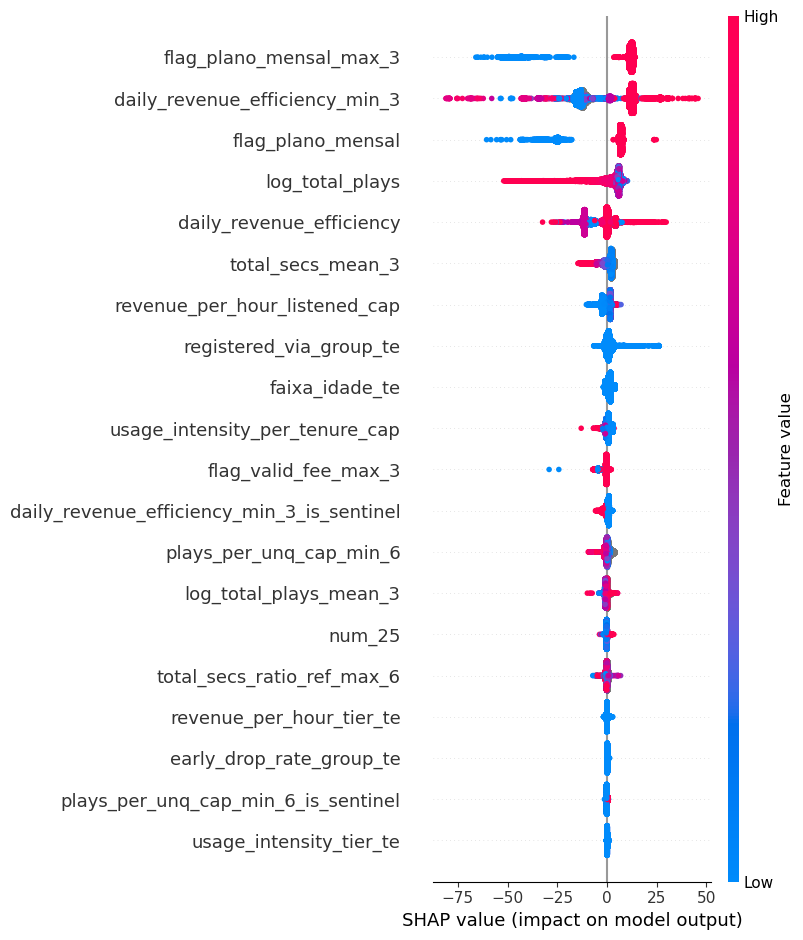

In [ ]:
shap.summary_plot(shap_values, X_shap, max_display=20)

**Interpretação do SHAP – Modelo LightGBM**

Agora estamos analisando como o modelo toma decisões individuais, não apenas a importância global das variáveis.

Vou dividir em três partes:

1. Como ler o **SHAP summary plot**
2. O que ele está dizendo sobre o modelo

---

**1. Como ler o SHAP Summary Plot**

- Cada linha representa uma feature;
- Cada ponto representa uma observação (usuário/linha do dataset).

**Eixo X (horizontal)**

O valor no eixo X é o **SHAP value**, que mostra o impacto daquela variável na predição.

- Valores **positivos** → empurram a predição **para cima**
- Valores **negativos** → empurram a predição **para baixo**
- Quanto mais distante do zero, maior o impacto

**Cor dos pontos**

A cor indica o **valor real da feature** naquela observação:

- **Azul** → valor baixo
- **Vermelho/Rosa** → valor alto

Isso permite ver o padrão quando a variável é alta, ela aumenta ou diminui a predição?

---

**2. O que o gráfico revela sobre o modelo**

**`flag_plano_mensal_max_3`**

- Pontos vermelhos (valor = 1) estão à direita → aumentam a predição
- Pontos azuis (valor = 0) estão à esquerda → diminuem a predição

**Interpretação:**  
Ter sido mensal nos últimos 3 meses aumenta fortemente a previsão do modelo.

**`flag_plano_mensal`**

Mesmo padrão, mas com impacto um pouco menor.

O modelo diferencia:
- Nunca foi mensal
- Já foi mensal
- É mensal agora

**`daily_revenue_efficiency_min_3`**

Padrão bem claro e monotônico:

- Eficiência alta → aumenta predição
- Eficiência baixa → reduz predição

Variável comportamental forte e consistente.

**`log_total_plays`**

- Muito uso → impacto positivo
- Pouco uso → impacto negativo

O modelo está capturando **engajamento real do usuário**.

**`total_secs_mean_3`**

- Mais tempo ouvindo → aumenta a previsão
- Menos tempo → diminui

Reflete intensidade de consumo.

**Variáveis *sentinel***

Exemplo: `daily_revenue_efficiency_min_3_is_sentinel`. Quando essa flag está ativa (valor alto), ela costuma empurrar a predição de forma consistente. A ausência de histórico ou comportamento extremo é informativa para o modelo.

---

##### Predição individual

In [ ]:
i = 0
x0 = X_shap.iloc[i:i+1]

pred0 = model_lgbm_final.predict(x0)[0]
base_value = explainer.expected_value

print("Pred:", pred0)
print("Base value (E[f(x)]):", base_value)
print("Base + sum(SHAP):", base_value + shap_values[i].sum())

Pred: 61.94651290453658
Base value (E[f(x)]): 43.675988800888376
Base + sum(SHAP): 61.94651290453632


**Entendendo a predição individual**

Valores fornecidos:
* Pred: 61.9465
* Base value: 43.6759
* Base + sum(SHAP): 61.9465

SHAP segue a equação:

$$ \text{Predição Final} = E[f(X)] + \sum_{j=1}^{M} \phi_j $$

Onde:
*   **Valor Base ($E[f(X)]$):** É a média das predições do modelo sobre todo o conjunto de treino. Representa o que o modelo preveria se não conhecesse nenhuma informação sobre o cliente.
*   **$\phi_j$ (SHAP Value):** É o impacto (positivo ou negativo) da variável $j$ para deslocar a predição do valor médio até o valor final observado.
*   **$M$:** Número total de variáveis (features).

Se o valor médio da margem líquida no treino é **43.67** (Valor Base) e o modelo prevê **61.94** para um cliente específico, a soma de todos os SHAP values desse cliente será exatamente **18.27**. O gráfico de SHAP detalha quais variáveis "empurraram" a predição para cima (ex: alta eficiência de receita) e quais "puxaram" para baixo (ex: baixa intensidade de uso).

Exemplo ilustrativo:

| Feature | SHAP | Efeito |
|--------|------|--------|
| Plano recente | +12 | Aumenta |
| Plano atual | +6 | Aumenta |
| Alta eficiência | +5 | Aumenta |
| Baixo tempo de uso | -3 | Diminui |
| Idade | -2 | Diminui |

Soma dos SHAP ≈ +18.27

**Interpretação dessa predição**

O usuário está bem acima da média do modelo:

- Média geral: 43.7  
- Usuário: 61.9  

As características dele empurraram a previsão para cima, provavelmente por:

- Ser ou ter sido usuário mensal
- Ter boa eficiência de receita
- Ter bom nível de uso

---

**Resumo**

| Elemento | Significado |
|----------|-------------|
| Base value | Previsão média do modelo |
| SHAP value | Impacto individual de cada variável |
| SHAP > 0 | Aumenta a predição |
| SHAP < 0 | Diminui a predição |
| Summary plot | Direção e força do efeito de cada variável |

O modelo mostra um comportamento coerente:
- Variáveis de plano geram grandes mudanças
- Variáveis de uso fazem ajustes graduais
- SHAP confirma os padrões vistos no GAIN

### 13.4.9. Salvar base

In [ ]:
gold_path = "C:/Users/Gustavo/Downloads/datamaster/dados/gold/"

In [ ]:
print("="*60)
print("GERANDO PREDIÇÕES (TRAIN/TEST/OOT)")
print("="*60)

def add_predictions(pdf, set_name):
    """Adiciona predições e resíduos ao dataframe"""
    pdf = pdf.copy()
    pdf["prediction_lgbm"] = model_lgbm_final.predict(pdf[feature_cols])
    pdf["residual_lgbm"] = pdf["target_win"] - pdf["prediction_lgbm"]
    pdf["set"] = set_name
    return pdf

# Gerar predições
train_pred_pd = add_predictions(train_pd, "train")
test_pred_pd  = add_predictions(test_pd,  "test")
oot_pred_pd   = add_predictions(oot_pd,   "oot")

print(f"✅ Train: {train_pred_pd.shape}")
print(f"✅ Test:  {test_pred_pd.shape}")
print(f"✅ OOT:   {oot_pred_pd.shape}")

# Selecionar colunas relevantes (reduz tamanho do arquivo)
keep_cols = [
    "msno", 
    "safra", 
    "partition",
    "set",
    "target_win", 
    "prediction_lgbm", 
    "residual_lgbm"
] + feature_cols

train_pred_pd = train_pred_pd[keep_cols]
test_pred_pd  = test_pred_pd[keep_cols]
oot_pred_pd   = oot_pred_pd[keep_cols]

# Consolidar tudo
all_pred_pd = pd.concat([train_pred_pd, test_pred_pd, oot_pred_pd], ignore_index=True)
print(f"\n✅ Base consolidada: {all_pred_pd.shape}")
print(f"   Colunas: {list(all_pred_pd.columns)}")

GERANDO PREDIÇÕES (TRAIN/TEST/OOT)
✅ Train: (6262831, 38)
✅ Test:  (1565303, 38)
✅ OOT:   (1850732, 38)

✅ Base consolidada: (9678866, 38)
   Colunas: ['msno', 'safra', 'partition', 'set', 'target_win', 'prediction_lgbm', 'residual_lgbm', 'daily_revenue_efficiency', 'daily_revenue_efficiency_min_3', 'daily_revenue_efficiency_min_3_is_sentinel', 'flag_plano_mensal', 'flag_plano_mensal_max_3', 'flag_valid_fee_max_3', 'log_total_plays', 'log_total_plays_mean_3', 'log_total_plays_mean_3_is_sentinel', 'num_25', 'num_50', 'num_75', 'num_985', 'plays_per_unq_cap_min_6', 'plays_per_unq_cap_min_6_is_sentinel', 'revenue_per_hour_listened_cap', 'total_secs_mean_3', 'total_secs_mean_3_is_sentinel', 'total_secs_ratio_ref_max_6', 'total_secs_ratio_ref_max_6_is_sentinel', 'usage_intensity_per_tenure_cap', 'avg_secs_per_unq_cap_group_te', 'early_drop_rate_group_te', 'faixa_idade_te', 'gender_clean_te', 'plays_behavior_vs_completion_collapsed_te', 'plays_per_unq_behavior_te', 'registered_via_group_te',

In [ ]:
print("="*60)
print("CONVERTENDO E SALVANDO DIRETO")
print("="*60)

# Caminho de saída
out_path = gold_path + "df_predictions_lightgbm"

# Converter tudo de uma vez
df_predictions_lightgbm = spark.createDataFrame(all_pred_pd)

# Salvar particionado
(
    df_predictions_lightgbm.write
    .mode("overwrite")
    .partitionBy("safra")
    .parquet(out_path)
)

print(f"✅ Sucesso! Predições salvas em: {out_path}")

CONVERTENDO E SALVANDO DIRETO
✅ Sucesso! Predições salvas em: C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_predictions_lightgbm


Obs.: depois me liguei que não precisava ter mandado para Spark DF para salvar como .parquet, o Pandas também faz isso e seria menos pesado.

### 13.4.10. Salvar modelo + metadados

In [ ]:
path_model = "C:/Users/Gustavo/Downloads/datamaster/models/"

In [ ]:
print("\n" + "="*60)
print("SALVANDO MODELO E METADADOS")
print("="*60)

import os
import json
import joblib

# Criar diretório
os.makedirs(path_model, exist_ok=True)

# 4.1 Salvar modelo completo (joblib) - para reuso em Python
model_path_pkl = os.path.join(path_model, "model.pkl")
joblib.dump(model_lgbm_final, model_path_pkl)
print(f"✅ Modelo (joblib) salvo: {model_path_pkl}")

# 4.2 Salvar booster nativo (formato LightGBM) - portável
booster_path = os.path.join(path_model, "booster.txt")
model_lgbm_final.booster_.save_model(booster_path)
print(f"✅ Booster (LightGBM) salvo: {booster_path}")

# 4.3 Salvar metadados (features, params, best_iteration)
metadata = {
    "model_type": "LightGBMRegressor",
    "optimization": "Hyperopt (Bayesian)",
    "n_trials": 50,
    "feature_cols": feature_cols,
    "n_features": len(feature_cols),
    "best_iteration": int(getattr(model_lgbm_final, "best_iteration_", -1)),
    "params": model_lgbm_final.get_params(),
    "train_shape": list(X_train.shape),
    "test_shape": list(X_test.shape),
    "oot_shape": list(X_oot.shape)
}

metadata_path = os.path.join(path_model, "metadata.json")
with open(metadata_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2, default=str)
print(f"✅ Metadados salvos: {metadata_path}")

print("\n" + "="*60)
print("✅ TUDO SALVO COM SUCESSO!")
print("="*60)


SALVANDO MODELO E METADADOS
✅ Modelo (joblib) salvo: C:/Users/Gustavo/Downloads/datamaster/models/model.pkl
✅ Booster (LightGBM) salvo: C:/Users/Gustavo/Downloads/datamaster/models/booster.txt
✅ Metadados salvos: C:/Users/Gustavo/Downloads/datamaster/models/metadata.json

✅ TUDO SALVO COM SUCESSO!


## 13.5. Random Forest Regressor

### 13.5.1. Carregando bibliotecas e bases

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

c:\Users\Gustavo\anaconda3\envs\new_datamaster\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
df_master_random_forest = spark.read.parquet(gold_path + "df_master_random_forest")

In [ ]:
# Definir as 31 features
feature_cols = [
    "daily_revenue_efficiency",
    "daily_revenue_efficiency_min_3",
    "daily_revenue_efficiency_min_3_is_sentinel",
    "flag_plano_mensal",
    "flag_plano_mensal_max_3",
    "flag_valid_fee_max_3",
    "log_total_plays",
    "log_total_plays_mean_3",
    "log_total_plays_mean_3_is_sentinel",
    "num_25",
    "num_50",
    "num_75",
    "num_985",
    "plays_per_unq_cap_min_6",
    "plays_per_unq_cap_min_6_is_sentinel",
    "revenue_per_hour_listened_cap",
    "total_secs_mean_3",
    "total_secs_mean_3_is_sentinel",
    "total_secs_ratio_ref_max_6",
    "total_secs_ratio_ref_max_6_is_sentinel",
    "usage_intensity_per_tenure_cap",
    "avg_secs_per_unq_cap_group_te",
    "early_drop_rate_group_te",
    "faixa_idade_te",
    "gender_clean_te",
    "plays_behavior_vs_completion_collapsed_te",
    "plays_per_unq_behavior_te",
    "registered_via_group_te",
    "revenue_per_hour_tier_te",
    "total_plays_group_te",
    "usage_intensity_tier_te"
]

# Converter para Pandas (processo pesado, mas necessário para usar com LightGBM e Hyperopt)
print("Convertendo Spark → Pandas...")
df_rf_pd = df_master_random_forest.select(["msno", "safra", "partition", "target_win"] + feature_cols).toPandas()
print("Feito!")

Convertendo Spark → Pandas...
Feito!


In [ ]:
# Split
train_pd = df_rf_pd[df_rf_pd["partition"] == "train"].copy()
test_pd  = df_rf_pd[df_rf_pd["partition"] == "test"].copy()
oot_pd   = df_rf_pd[df_rf_pd["partition"] == "oot"].copy()

X_train = train_pd[feature_cols]
y_train = train_pd["target_win"]

X_test = test_pd[feature_cols]
y_test = test_pd["target_win"]

X_oot = oot_pd[feature_cols]
y_oot = oot_pd["target_win"]

print(f"Train: {X_train.shape} | Test: {X_test.shape} | OOT: {X_oot.shape}")

Train: (6262831, 31) | Test: (1565303, 31) | OOT: (1850732, 31)


### 13.5.2. Configurações Hyperopt

#### 13.5.2.1. Primeira configuração (pesada para os 6 milhões de registros de treino)

In [ ]:
# Definir espaço de busca para Hyperopt
space_rf = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', 0.5, 0.7]),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_samples': hp.uniform('max_samples', 0.6, 1.0)  # só funciona se bootstrap=True
}

In [ ]:
def objective_rf(params):
    # Converter para int os parâmetros discretos
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    
    # Se bootstrap=False, max_samples não é usado (remover para evitar warning)
    if not params['bootstrap']:
        params.pop('max_samples', None)
    
    # Criar modelo
    model = RandomForestRegressor(
        **params,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    # Treinar
    model.fit(X_train, y_train)
    
    # Avaliar no TEST
    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    
    return {'loss': rmse, 'status': STATUS_OK}

#### 13.5.2.2. Segunda configuração (melhor desempenho)

In [ ]:
# Espaço de busca mais leve
space_rf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 50),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 50, 5),
    'max_features': hp.choice('max_features', ['sqrt', 0.5]),
    'bootstrap': hp.choice('bootstrap', [True])
}

In [ ]:
def objective_rf(params):
    # Converter para int
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    
    # Criar modelo
    model = RandomForestRegressor(
        **params,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    # Treinar na AMOSTRA
    model.fit(X_train_sample, y_train_sample)
    
    # Avaliar no TEST completo
    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    
    return {'loss': rmse, 'status': STATUS_OK}

### 13.5.3. Encontrando melhores hiperparâmetros

#### 13.5.3.1. Primeira execução

In [ ]:
print("\n" + "="*60)
print("INICIANDO OTIMIZAÇÃO BAYESIANA VIA HYPEROPT")
print("="*60)
print("Isso pode levar um tempo. Aguarde...")

trials_rf = Trials()
best_rf = fmin(
    fn=objective_rf,
    space=space_rf,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_rf,
    rstate=np.random.default_rng(42),
    verbose=1
)

print("\n" + "="*60)
print("OTIMIZAÇÃO CONCLUÍDA!")
print("="*60)
print("\n🏆 Melhores Hiperparâmetros:")
for key, value in best_rf.items():
    print(f"  {key}: {value}")


INICIANDO OTIMIZAÇÃO BAYESIANA VIA HYPEROPT
Isso pode levar um tempo. Aguarde...
  2%|▏         | 1/50 [13:40<11:09:44, 820.10s/trial, best loss: 37.59801678612831]


KeyboardInterrupt: 

Foram cinco minutos para rodar apenas um conjunto de parâmetros! RF é mais pesada que LightGBM, e tende a não acertar tão bem quanto ele. Vou amostrar os dados.

#### 13.5.3.2. Construindo amostragem dos dados

**Por que pegar amostra de dados?**

*   Complexidade de Memória: O Random Forest tenta carregar e processar os dados de forma diferente. Com 6 milhões de linhas e 31 colunas, o custo de memória e CPU para criar uma única árvore profunda é gigantesco;
*   Falta de Binning: O LightGBM transforma variáveis numéricas em "bins", o que acelera o treino dezenas de vezes. O Random Forest padrão testa todos os pontos de corte possíveis, o que é impraticável nessa volumetria;
*   N_jobs=-1: Se o primeiro trial pegar um parâmetro de `n_estimators=500` e `max_depth=30`, o PC pode "engasgar" para processar tudo em paralelo.

Para este case, não me parece fazer sentido ficar horas esperando um modelo que provavelmente será pior que o LightGBM. Como o RF atinge a convergência estatística muito antes de 6 milhões de linhas, treinar com uma amostra de 1 milhão de linhas (ou até 500k) dará resultados quase idênticos e será muito mais rápido.

In [ ]:
# Amostra de 1kk linhas - estatisticamente suficiente para achar bons parâmetros
X_train_sample = X_train.sample(n=min(1000000, len(X_train)), random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

print(f"Amostra de treino para Hyperopt: {X_train_sample.shape}")
print(f"Test completo: {X_test.shape}")
print(f"OOT completo: {X_oot.shape}")

Amostra de treino para Hyperopt: (1000000, 31)
Test completo: (1565303, 31)
OOT completo: (1850732, 31)


#### 13.5.3.3. Segunda execução

In [ ]:
print("\n" + "="*60)
print("INICIANDO OTIMIZAÇÃO BAYESIANA VIA HYPEROPT")
print("="*60)
print("Isso pode alguns minutos. Aguarde...")

trials_rf = Trials()
best_rf = fmin(
    fn=objective_rf,
    space=space_rf,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_rf,
    rstate=np.random.default_rng(42),
    verbose=1
)

print("\n" + "="*60)
print("OTIMIZAÇÃO CONCLUÍDA!")
print("="*60)
print("\n🏆 Melhores Hiperparâmetros (raw):")
print(best_rf)


INICIANDO OTIMIZAÇÃO BAYESIANA VIA HYPEROPT
Isso pode alguns minutos. Aguarde...
100%|██████████| 50/50 [51:56<00:00, 62.33s/trial, best loss: 36.06878821535873] 

OTIMIZAÇÃO CONCLUÍDA!

🏆 Melhores Hiperparâmetros (raw):
{'bootstrap': np.int64(0), 'max_depth': np.float64(13.0), 'max_features': np.int64(1), 'min_samples_leaf': np.float64(25.0), 'n_estimators': np.float64(150.0)}


### 13.5.4. Treinando modelo com melhores hiperparâmetros

In [ ]:
print("\n" + "="*60)
print("TREINANDO MODELO FINAL COM MELHORES PARÂMETROS")
print("="*60)

# Reconstruir params (cuidado com hp.choice)
best_params_rf = {
    'n_estimators': int(best_rf['n_estimators']),
    'max_depth': int(best_rf['max_depth']),
    'min_samples_leaf': int(best_rf['min_samples_leaf']),
    'max_features': ['sqrt', 0.5][best_rf['max_features']],
    'bootstrap': [True][best_rf['bootstrap']],  # Sempre True no nosso space
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 0
}

print("Parâmetros finais:")
for k, v in best_params_rf.items():
    print(f"  {k}: {v}")

# Treinar no dataset COMPLETO
model_rf_final = RandomForestRegressor(**best_params_rf)
model_rf_final.fit(X_train, y_train)

print(f"✅ Modelo treinado com {model_rf_final.n_estimators} árvores")


TREINANDO MODELO FINAL COM MELHORES PARÂMETROS
Parâmetros finais:
  n_estimators: 150
  max_depth: 13
  min_samples_leaf: 25
  max_features: 0.5
  bootstrap: True
  random_state: 42
  n_jobs: -1
  verbose: 0
✅ Modelo treinado com 150 árvores


### 13.5.5. Resultados (Test + OOT)

In [ ]:
print("\n" + "="*60)
print("AVALIAÇÃO FINAL - RANDOM FOREST (TUNED)")
print("="*60)

for name, X, y in [("TEST", X_test, y_test), ("OOT", X_oot, y_oot)]:
    preds = model_rf_final.predict(X)
    rmse = root_mean_squared_error(y, preds)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    
    print(f"\n--- {name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")


AVALIAÇÃO FINAL - RANDOM FOREST (TUNED)

--- TEST ---
RMSE: 36.1329
MAE:  19.9147
R²:   0.6438

--- OOT ---
RMSE: 30.6644
MAE:  15.7750
R²:   0.6685


### 13.5.6. Comparação dos modelos executados até então

In [ ]:
print("\n" + "="*60)
print("📊 COMPARAÇÃO DE TODOS OS MODELOS (OOT)")
print("="*60)

preds_rf_oot = model_rf_final.predict(X_oot)
rmse_rf = root_mean_squared_error(y_oot, preds_rf_oot)
mae_rf = mean_absolute_error(y_oot, preds_rf_oot)
r2_rf = r2_score(y_oot, preds_rf_oot)

comparison = pd.DataFrame({
    'Modelo': ['Elastic Net', 'Decision Tree (Baseline)', 'LightGBM (Tuned)', 'Random Forest (Tuned)'],
    'RMSE OOT': [32.27, 31.30, 30.32, rmse_rf],
    'MAE OOT': [16.62, 15.32, 13.96, mae_rf],
    'R² OOT': [0.633, 0.654, 0.676, r2_rf]
})

print(comparison.to_string(index=False))

# Ganhos
ganho_rmse_en = ((32.27 - rmse_rf) / 32.27) * 100
ganho_mae_en = ((16.62 - mae_rf) / 16.62) * 100
diff_rmse_lgbm = ((rmse_rf - 30.32) / 30.32) * 100
diff_mae_lgbm = ((mae_rf - 13.96) / 13.96) * 100

print(f"\n🎯 Ganho do Random Forest vs Elastic Net:")
print(f"   RMSE: {ganho_rmse_en:+.2f}%")
print(f"   MAE:  {ganho_mae_en:+.2f}%")

print(f"\n🔍 Random Forest vs LightGBM:")
print(f"   RMSE: {diff_rmse_lgbm:+.2f}%")
print(f"   MAE:  {diff_mae_lgbm:+.2f}%")


📊 COMPARAÇÃO DE TODOS OS MODELOS (OOT)
                  Modelo  RMSE OOT   MAE OOT   R² OOT
             Elastic Net 32.270000 16.620000 0.633000
Decision Tree (Baseline) 31.300000 15.320000 0.654000
        LightGBM (Tuned) 30.320000 13.960000 0.676000
   Random Forest (Tuned) 30.664446 15.775009 0.668457

🎯 Ganho do Random Forest vs Elastic Net:
   RMSE: +4.98%
   MAE:  +5.08%

🔍 Random Forest vs LightGBM:
   RMSE: +1.14%
   MAE:  +13.00%


### 13.5.7. Conclusões sobre os resultados

O Random Forest apresentou uma performance de generalização (OOT) robusta, com um R² de 0.668, superando o Elastic Net e a Decision Tree.

Ao comparar com o LightGBM, observamos que o Random Forest obteve um RMSE muito competitivo (apenas 1.14% superior), indicando excelente controle sobre grandes erros. No entanto, o MAE foi 13% superior ao LightGBM.

Essa divergência sugere que, enquanto o LightGBM é mais preciso na estimativa pontual da maioria dos clientes (menor MAE), o Random Forest oferece uma estimativa mais estável e conservadora, sendo menos propenso a overfitting em casos extremos, embora sacrifique a precisão média no processo.

### 13.5.8. Feature Importance

#### 13.5.8.1. Mean Decrease Impurity (MDI)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("FEATURE IMPORTANCE - RANDOM FOREST (MDI/GAIN)")
print("="*60)

# Extrair importâncias do modelo treinado
importances_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_rf_final.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

# Adicionar importância relativa (%)
importances_rf['importance_pct'] = (importances_rf['importance'] / importances_rf['importance'].sum()) * 100

# Adicionar importância acumulada
importances_rf['importance_cumsum'] = importances_rf['importance_pct'].cumsum()

print("\n📊 Top 15 Features (Random Forest):")
print(importances_rf.head(15).to_string(index=False))

# Identificar quantas features explicam 80% da importância
n_features_80 = (importances_rf['importance_cumsum'] <= 80).sum()
print(f"\n🎯 {n_features_80} features explicam 80% da importância total")

FEATURE IMPORTANCE - RANDOM FOREST (MDI/GAIN)

📊 Top 15 Features (Random Forest):
                                   feature  importance  importance_pct  importance_cumsum
                   flag_plano_mensal_max_3    0.383604       38.360427          38.360427
                         flag_plano_mensal    0.188339       18.833896          57.194322
                  daily_revenue_efficiency    0.131438       13.143784          70.338106
            daily_revenue_efficiency_min_3    0.121355       12.135483          82.473589
                      flag_valid_fee_max_3    0.044264        4.426402          86.899991
                           log_total_plays    0.038924        3.892389          90.792381
             revenue_per_hour_listened_cap    0.015729        1.572866          92.365246
                         total_secs_mean_3    0.014631        1.463149          93.828395
                   registered_via_group_te    0.011799        1.179863          95.008258
                  

Correcao: sao na verdade 4 features, pra passar de 70% para 82%*

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_26864\1224318005.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_15, y='feature', x='importance_pct', palette='viridis')


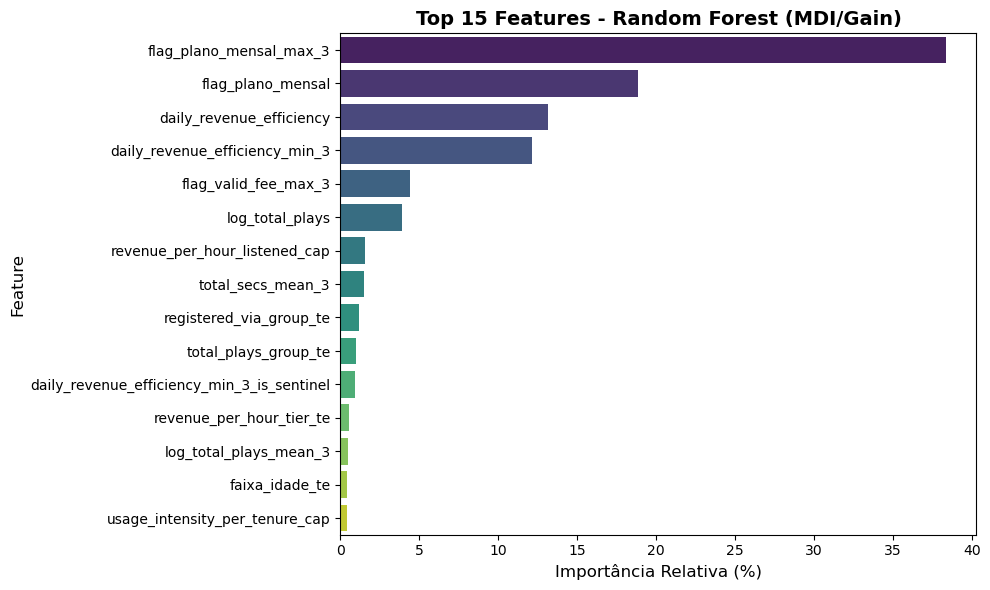

In [ ]:
# ============================================================
# VISUALIZAÇÃO 1: Top 15 Features (Barplot)
# ============================================================
plt.figure(figsize=(10, 6))
top_15 = importances_rf.head(15)
sns.barplot(data=top_15, y='feature', x='importance_pct', palette='viridis')
plt.title('Top 15 Features - Random Forest (MDI/Gain)', fontsize=14, fontweight='bold')
plt.xlabel('Importância Relativa (%)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

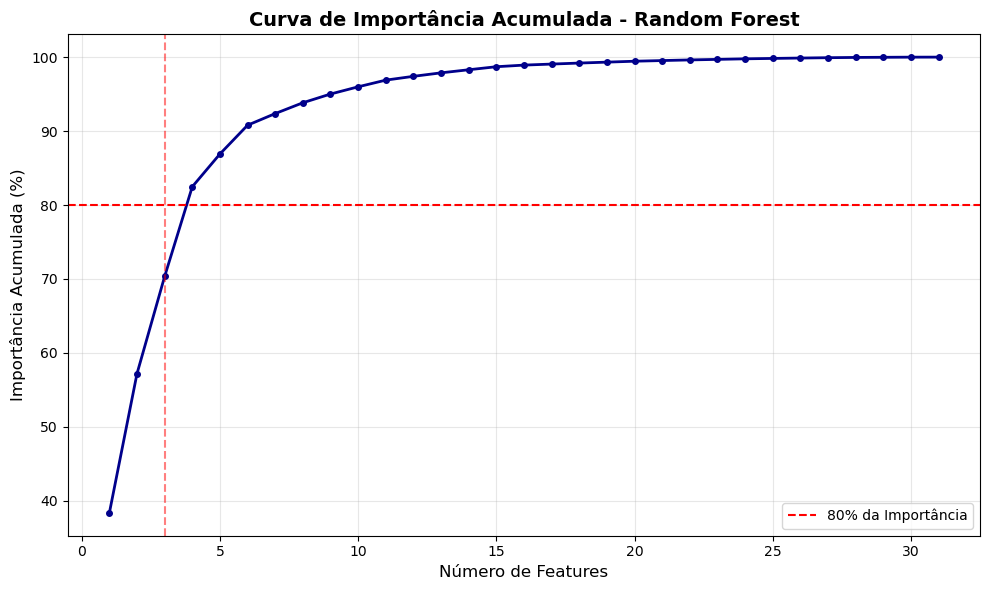

In [ ]:
# ============================================================
# VISUALIZAÇÃO 2: Curva de Importância Acumulada
# ============================================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(importances_rf) + 1), importances_rf['importance_cumsum'], 
         marker='o', linewidth=2, markersize=4, color='darkblue')
plt.axhline(y=80, color='red', linestyle='--', linewidth=1.5, label='80% da Importância')
plt.axvline(x=n_features_80, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
plt.title('Curva de Importância Acumulada - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Número de Features', fontsize=12)
plt.ylabel('Importância Acumulada (%)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

A importância nativa, baseada em MDI (Mean Decrease Impurity) ou Gain, mede o quanto cada variável contribuiu para reduzir a incerteza (impureza) nos nós das árvores durante o treinamento.

- Concentração de Importância: Apenas 3 features explicam 80% do comportamento do modelo. Isso indica um modelo muito eficiente, que foca em sinais claros de faturamento e tipo de contrato;
- Top Features: flag_plano_mensal_max_3 (38.36%) e flag_plano_mensal (18.83%) dominam, mostrando que a estratégia de assinatura é o maior preditor de rentabilidade;
- Eficiência de Receita: daily_revenue_efficiency aparece com destaque (13.14%), validando que o quão eficiente o cliente é em gerar receita por dia é um diferencial crítico.

#### 13.5.8.2. SHAP Values

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("="*60)
print("SHAP VALUES - RANDOM FOREST")
print("="*60)
print("⚠️  Isso pode levar alguns minutos. Aguarde...")

# ============================================================
# 1. CRIAR AMOSTRA PARA O SHAP (Acelera o cálculo)
# ============================================================
# SHAP no RF pode ser lento. Usamos 5.000 linhas do OOT
np.random.seed(42)
sample_indices = np.random.choice(X_oot.index, size=min(5000, len(X_oot)), replace=False)
X_shap = X_oot.loc[sample_indices]

print(f"Amostra para SHAP: {X_shap.shape}")

# ============================================================
# 2. CALCULAR SHAP VALUES
# ============================================================
explainer = shap.TreeExplainer(model_rf_final)
shap_values = explainer.shap_values(X_shap)

print(f"✅ SHAP values calculados: {shap_values.shape}")

c:\Users\Gustavo\anaconda3\envs\new_datamaster\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP VALUES - RANDOM FOREST
⚠️  Isso pode levar alguns minutos. Aguarde...
Amostra para SHAP: (5000, 31)
✅ SHAP values calculados: (5000, 31)


In [ ]:
i = 1
x0 = X_shap.iloc[i:i+1]

pred0 = model_rf_final.predict(x0)[0]
base_value = explainer.expected_value

print("Pred:", pred0)
print("Base value (E[f(x)]):", base_value)
print("Base + sum(SHAP):", base_value + shap_values[i].sum())

Pred: 84.92638753968073
Base value (E[f(x)]): [43.67735657]
Base + sum(SHAP): [84.92638754]



📊 Gerando Summary Plot (Beeswarm)...


C:\Users\Gustavo\AppData\Local\Temp\ipykernel_26864\3263841930.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, feature_names=feature_cols, show=False, max_display=15)


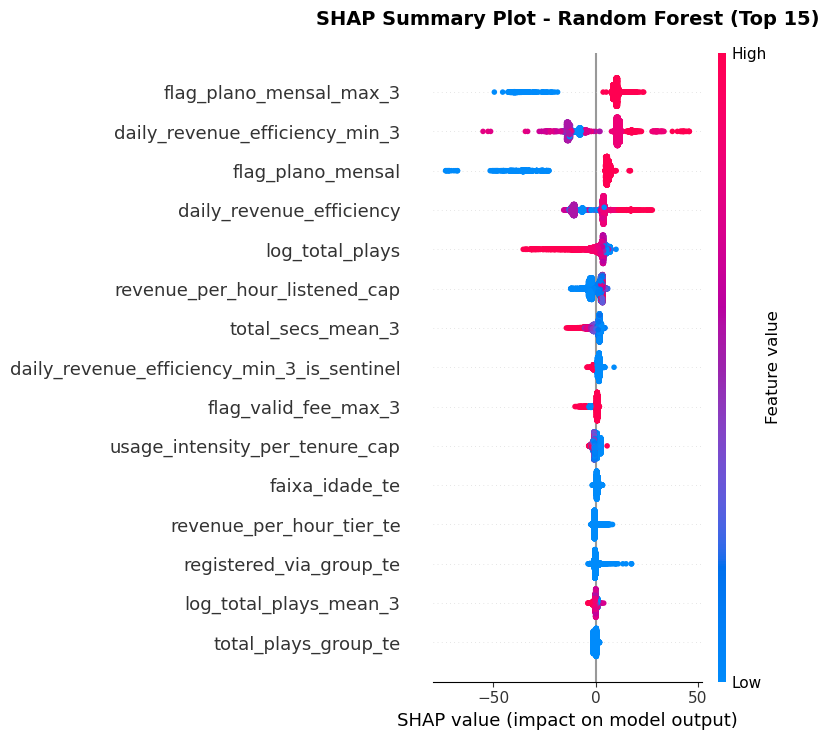

In [ ]:
# ============================================================
# 3. VISUALIZAÇÃO 1: Summary Plot (Beeswarm)
# ============================================================
print("\n📊 Gerando Summary Plot (Beeswarm)...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, feature_names=feature_cols, show=False, max_display=15)
plt.title('SHAP Summary Plot - Random Forest (Top 15)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 5. TABELA: SHAP Importance (Mean Absolute SHAP)
# ============================================================
shap_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'shap_importance': np.abs(shap_values).mean(axis=0)
}).sort_values('shap_importance', ascending=False).reset_index(drop=True)

# Adicionar importância relativa (%)
shap_importance_rf['shap_importance_pct'] = (
    shap_importance_rf['shap_importance'] / shap_importance_rf['shap_importance'].sum()
) * 100

# Adicionar importância acumulada
shap_importance_rf['shap_cumsum'] = shap_importance_rf['shap_importance_pct'].cumsum()

print("\n📊 Top 15 Features (SHAP):")
print(shap_importance_rf.head(15).to_string(index=False))

# Identificar quantas features explicam 80% da importância SHAP
n_features_80_shap = (shap_importance_rf['shap_cumsum'] <= 80).sum()
print(f"\n🎯 {n_features_80_shap} features explicam 80% da importância SHAP")


📊 Top 15 Features (SHAP):
                                   feature  shap_importance  shap_importance_pct  shap_cumsum
                   flag_plano_mensal_max_3        12.492821            21.645152    21.645152
            daily_revenue_efficiency_min_3        11.952961            20.709787    42.354939
                         flag_plano_mensal         9.309943            16.130474    58.485413
                  daily_revenue_efficiency         7.164424            12.413133    70.898546
                           log_total_plays         4.376658             7.583029    78.481574
             revenue_per_hour_listened_cap         2.542718             4.405532    82.887107
                         total_secs_mean_3         2.118418             3.670386    86.557492
daily_revenue_efficiency_min_3_is_sentinel         1.480944             2.565894    89.123387
                      flag_valid_fee_max_3         0.943074             1.633977    90.757364
            usage_intensity_per_t

Diferente do MDI, o SHAP é baseado na "Teoria dos Jogos" e mostra a contribuição marginal de cada variável para a predição final em relação a um valor base (média). Percebe-se que, para o SHAP, são necessárias 5 features (em vez de 3) para explicar ~80% da importância. O SHAP "distribui" melhor a importância, valorizando mais o histórico de 3 meses (`daily_revenue_efficiency_min_3`).


📊 Gerando Waterfall Plot (Exemplo Individual)...


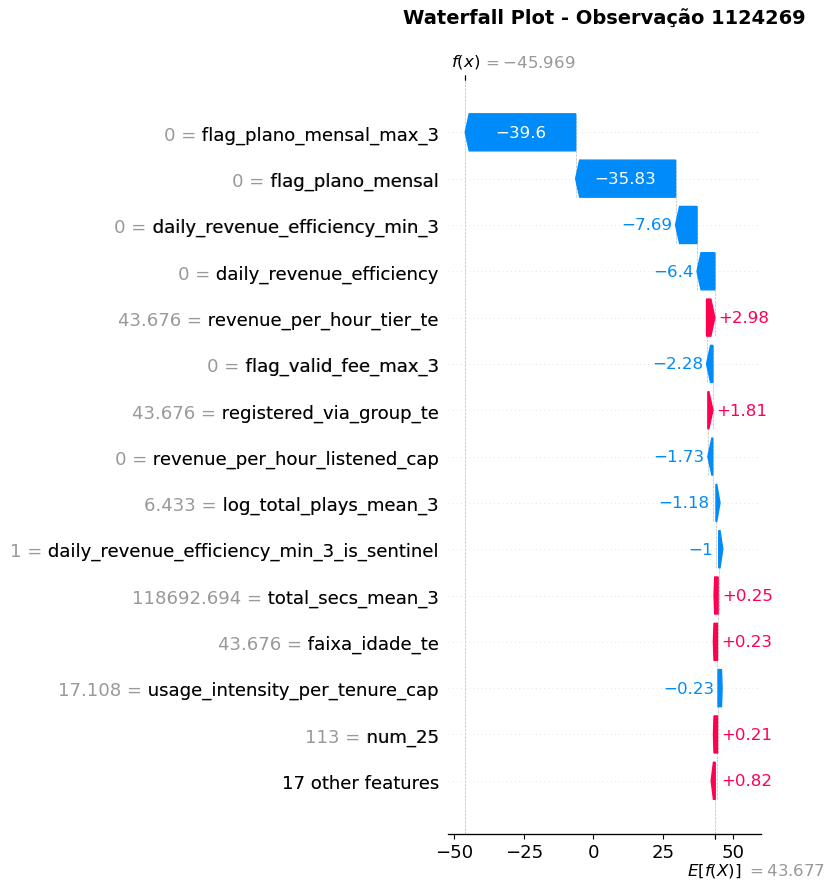

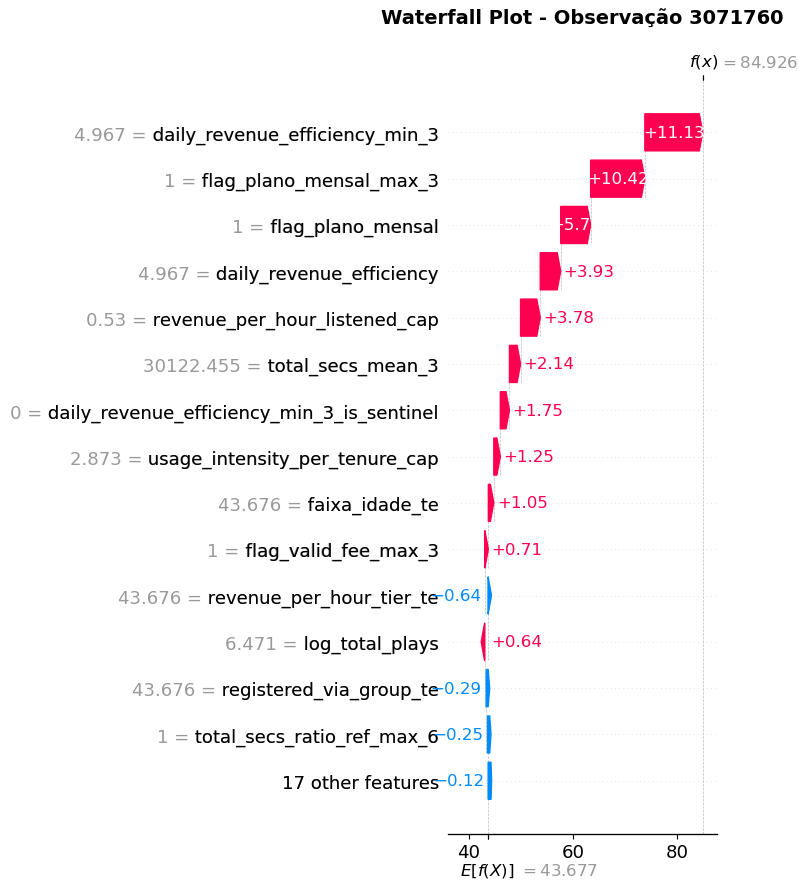

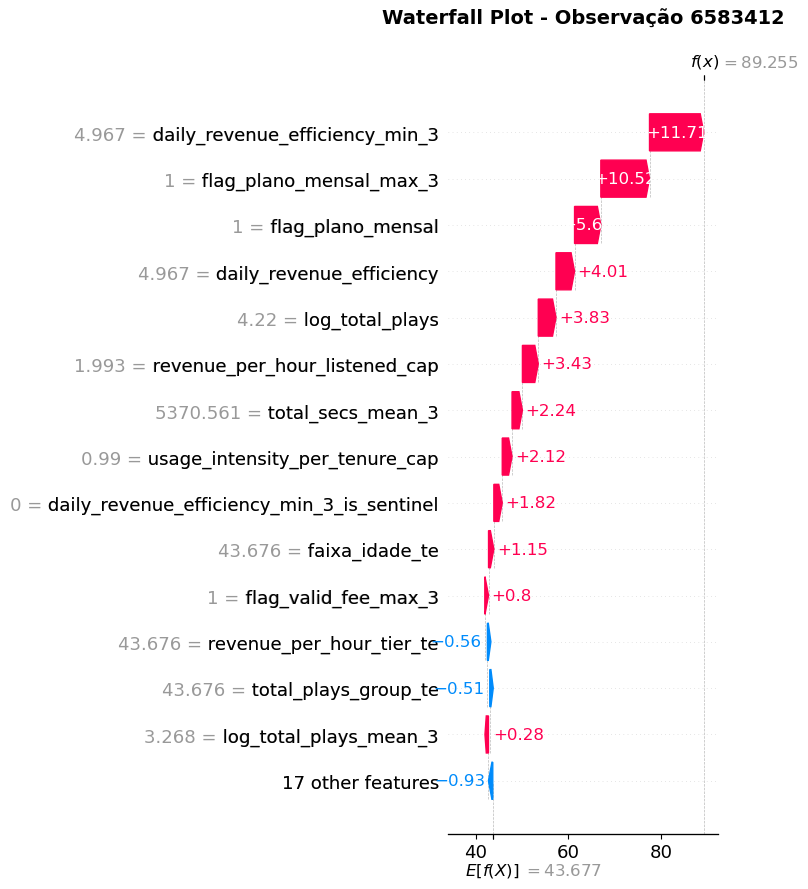

In [ ]:
print("\n📊 Gerando Waterfall Plot (Exemplo Individual)...")
# Pegar as primeiras 3 observacoes da amostra
for i in range (0, 3):
    sample_idx = i
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[sample_idx],
            base_values=explainer.expected_value,
            data=X_shap.iloc[sample_idx].values,
            feature_names=feature_cols
        ),
        max_display=15,
        show=False
    )
    plt.title(f'Waterfall Plot - Observação {sample_indices[sample_idx]}', 
            fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

- Primeiro cliente: exemplo de baixo valor. Percebe-se dominancia das setas azuis, mostrando que a ausência do plano mensal (`flag_plano_mensal_max_3 == 0`) "derrubou" a predição em quase 40 pontos;
- Seguno e terceiro clientes: exemplo de sucesso. As setas vermelhas "empurram" o valor para a direita, principalmente pelo status do plano mensal.


📊 Comparação: MDI (Nativo) vs SHAP (Top 10)...

COMPARAÇÃO: MDI vs SHAP (Top 10)
                                   feature   MDI_pct  shap_importance_pct
                  daily_revenue_efficiency 13.143784            12.413133
            daily_revenue_efficiency_min_3 12.135483            20.709787
daily_revenue_efficiency_min_3_is_sentinel  0.000000             2.565894
                         flag_plano_mensal 18.833896            16.130474
                   flag_plano_mensal_max_3 38.360427            21.645152
                      flag_valid_fee_max_3  4.426402             1.633977
                           log_total_plays  3.892389             7.583029
                   registered_via_group_te  1.179863             0.000000
             revenue_per_hour_listened_cap  1.572866             4.405532
                      total_plays_group_te  0.975780             0.000000
                         total_secs_mean_3  1.463149             3.670386
            usage_intensity_pe

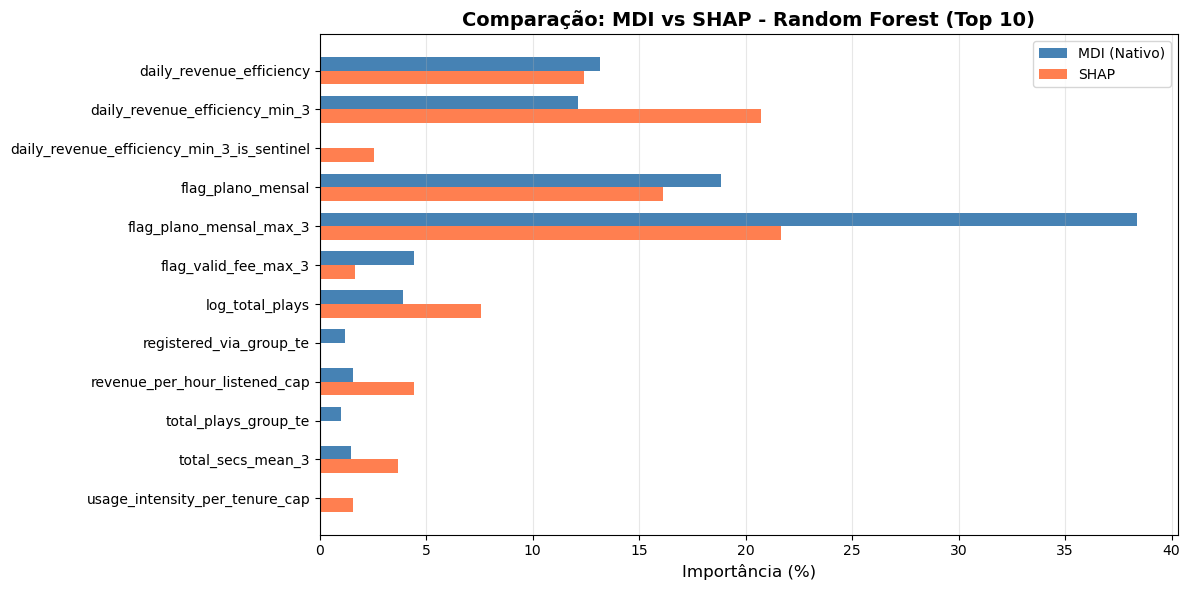


✅ SHAP VALUES (RANDOM FOREST) CONCLUÍDO!


In [ ]:
# ============================================================
# 8. COMPARAÇÃO: MDI vs SHAP (Top 10)
# ============================================================
print("\n📊 Comparação: MDI (Nativo) vs SHAP (Top 10)...")

comparison_importance = pd.merge(
    importances_rf[['feature', 'importance_pct']].head(10).rename(columns={'importance_pct': 'MDI_pct'}),
    shap_importance_rf[['feature', 'shap_importance_pct']].head(10),
    on='feature',
    how='outer'
).fillna(0)

print("\n" + "="*60)
print("COMPARAÇÃO: MDI vs SHAP (Top 10)")
print("="*60)
print(comparison_importance.to_string(index=False))

# Visualização comparativa
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_importance))
width = 0.35

ax.barh(x - width/2, comparison_importance['MDI_pct'], width, label='MDI (Nativo)', color='steelblue')
ax.barh(x + width/2, comparison_importance['shap_importance_pct'], width, label='SHAP', color='coral')

ax.set_yticks(x)
ax.set_yticklabels(comparison_importance['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importância (%)', fontsize=12)
ax.set_title('Comparação: MDI vs SHAP - Random Forest (Top 10)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✅ SHAP VALUES (RANDOM FOREST) CONCLUÍDO!")
print("="*60)

Este comparativo é a chave dessa análise. Atraves dele, entende duas diferencas principais: onde o algoritmo foca (MDI) vs o que realmente impacta o resultado final (SHAP).

- Divergências Positivas: features como `daily_revenue_efficiency_min_3` ganham muito mais relevância no SHAP (20.7%) do que no MDI (12.1%). Isso sugere que, embora o modelo use o plano mensal para criar as divisões principais nas árvores, o histórico de eficiência é o que dá o "ajuste fino" no valor final da margem;
- Flags de "Sentinela": `daily_revenue_efficiency_min_3_is_sentinel` e `usage_intensity_per_tenure_cap` aparece no SHAP mas é quase nula no MDI nativo. O SHAP consegue captar sinais sutis que a importância nativa ignora.
- Features categoricas (com TE): `registered_via_group_te` e `total_plays_group_te` com valores significativos somente no MDI.

### 13.5.9. Salvar base

In [ ]:
gold_path = "C:/Users/Gustavo/Downloads/datamaster/dados/gold/"

In [ ]:
print("="*60)
print("GERANDO PREDIÇÕES (TRAIN/TEST/OOT)")
print("="*60)

def add_predictions(pdf, set_name):
    """Adiciona predições e resíduos ao dataframe"""
    pdf = pdf.copy()
    pdf["prediction_rfr"] = model_rf_final.predict(pdf[feature_cols])
    pdf["residual_rfr"] = pdf["target_win"] - pdf["prediction_rfr"]
    pdf["set"] = set_name
    return pdf

# Gerar predições
train_pred_pd = add_predictions(train_pd, "train")
test_pred_pd  = add_predictions(test_pd,  "test")
oot_pred_pd   = add_predictions(oot_pd,   "oot")

print(f"✅ Train: {train_pred_pd.shape}")
print(f"✅ Test:  {test_pred_pd.shape}")
print(f"✅ OOT:   {oot_pred_pd.shape}")

# Selecionar colunas relevantes (reduz tamanho do arquivo)
keep_cols = [
    "msno", 
    "safra", 
    "partition",
    "set",
    "target_win", 
    "prediction_rfr", 
    "residual_rfr"
] + feature_cols

train_pred_pd = train_pred_pd[keep_cols]
test_pred_pd  = test_pred_pd[keep_cols]
oot_pred_pd   = oot_pred_pd[keep_cols]

# Consolidar tudo
all_pred_pd = pd.concat([train_pred_pd, test_pred_pd, oot_pred_pd], ignore_index=True)
print(f"\n✅ Base consolidada: {all_pred_pd.shape}")
print(f"   Colunas: {list(all_pred_pd.columns)}")

GERANDO PREDIÇÕES (TRAIN/TEST/OOT)
✅ Train: (6262831, 38)
✅ Test:  (1565303, 38)
✅ OOT:   (1850732, 38)

✅ Base consolidada: (9678866, 38)
   Colunas: ['msno', 'safra', 'partition', 'set', 'target_win', 'prediction_rfr', 'residual_rfr', 'daily_revenue_efficiency', 'daily_revenue_efficiency_min_3', 'daily_revenue_efficiency_min_3_is_sentinel', 'flag_plano_mensal', 'flag_plano_mensal_max_3', 'flag_valid_fee_max_3', 'log_total_plays', 'log_total_plays_mean_3', 'log_total_plays_mean_3_is_sentinel', 'num_25', 'num_50', 'num_75', 'num_985', 'plays_per_unq_cap_min_6', 'plays_per_unq_cap_min_6_is_sentinel', 'revenue_per_hour_listened_cap', 'total_secs_mean_3', 'total_secs_mean_3_is_sentinel', 'total_secs_ratio_ref_max_6', 'total_secs_ratio_ref_max_6_is_sentinel', 'usage_intensity_per_tenure_cap', 'avg_secs_per_unq_cap_group_te', 'early_drop_rate_group_te', 'faixa_idade_te', 'gender_clean_te', 'plays_behavior_vs_completion_collapsed_te', 'plays_per_unq_behavior_te', 'registered_via_group_te', '

In [ ]:
print("\n" + "="*60)
print("SALVANDO DIRETO EM PARQUET (PANDAS)")
print("="*60)

# Caminho de saída
out_path = gold_path + "df_predictions_random_forest"

# Salvar particionado por safra usando Pandas + PyArrow
all_pred_pd.to_parquet(
    out_path,
    engine='pyarrow',
    partition_cols=['safra'],
    compression='snappy',
    index=False
)

print(f"✅ Sucesso! Predições salvas em: {out_path}")
print(f"   Formato: Parquet particionado por safra")
print(f"   Engine: PyArrow")
print(f"   Compressão: Snappy")


SALVANDO DIRETO EM PARQUET (PANDAS)
✅ Sucesso! Predições salvas em: C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_predictions_random_forest
   Formato: Parquet particionado por safra
   Engine: PyArrow
   Compressão: Snappy


### 13.5.10. Salvar modelo + metadados

In [ ]:
path_model = "C:/Users/Gustavo/Downloads/datamaster/models/random_forest_regressor_model"

In [ ]:
print("\n" + "="*60)
print("SALVANDO MODELO E METADADOS")
print("="*60)

import os
import json
import joblib

# Criar diretório
os.makedirs(path_model, exist_ok=True)

# 4.1 Salvar modelo completo (joblib) - para reuso em Python
model_path_pkl = os.path.join(path_model, "model.pkl")
joblib.dump(model_rf_final, model_path_pkl)
print(f"✅ Modelo (joblib) salvo: {model_path_pkl}")

# 4.2 Salvar metadados (features, params, n_estimators)
metadata = {
    "model_type": "RandomForestRegressor",
    "optimization": "Hyperopt (Bayesian)",
    "n_trials": 50,
    "feature_cols": feature_cols,
    "n_features": len(feature_cols),
    "n_estimators": int(model_rf_final.n_estimators),
    "n_trees_trained": int(model_rf_final.n_estimators),  # Total de árvores treinadas
    "params": model_rf_final.get_params(),
    "train_shape": list(X_train.shape),
    "test_shape": list(X_test.shape),
    "oot_shape": list(X_oot.shape)
}

metadata_path = os.path.join(path_model, "metadata.json")
with open(metadata_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2, default=str)
print(f"✅ Metadados salvos: {metadata_path}")

print("\n" + "="*60)
print("✅ TUDO SALVO COM SUCESSO!")
print("="*60)


SALVANDO MODELO E METADADOS
✅ Modelo (joblib) salvo: C:/Users/Gustavo/Downloads/datamaster/models/random_forest_regressor_model\model.pkl
✅ Metadados salvos: C:/Users/Gustavo/Downloads/datamaster/models/random_forest_regressor_model\metadata.json

✅ TUDO SALVO COM SUCESSO!


## 13.6. Escolha do modelo finalista

### 13.6.1. Carregando bases de predições EN, LGBM, RFR

In [ ]:
df_predictions_elastic_net = spark.read.parquet(gold_path + "df_predictions_elastic_net")
df_predictions_lightgbm = spark.read.parquet(gold_path + "df_predictions_lightgbm")
df_predictions_random_forest = spark.read.parquet(gold_path + "df_predictions_random_forest")

In [ ]:
df_predictions_elastic_net.printSchema()

root
 |-- msno: string (nullable = true)
 |-- target_win: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = true)
 |-- actual_amount_paid: double (nullable = true)
 |-- flag_plano_mensal_max_3: integer (nullable = true)
 |-- log_total_secs_mean_3: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- usage_intensity_per_tenure_cap: double (nullable = true)
 |-- payment_method_group_ohe: vector (nullable = true)
 |-- revenue_tier_ohe: vector (nullable = true)
 |-- revenue_per_hour_tier_ohe: vector (nullable = true)
 |-- plays_behavior_vs_volume_collapsed_ohe: vector (nullable = true)
 |-- plays_behavior_vs_completion_collapsed_ohe: vector (nullable = true)
 |-- usage_intensity_tier_ohe: vector (nullable = true)
 |-- registered_via_group_ohe: vector (nullable = true)
 |-- faixa_idade_ohe: vector (nullable = true)
 |-- partition: string (nullab

In [ ]:
df_predictions_lightgbm.printSchema()

root
 |-- msno: string (nullable = true)
 |-- partition: string (nullable = true)
 |-- set: string (nullable = true)
 |-- target_win: double (nullable = true)
 |-- prediction_lgbm: double (nullable = true)
 |-- residual_lgbm: double (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- daily_revenue_efficiency_min_3_is_sentinel: long (nullable = true)
 |-- flag_plano_mensal: long (nullable = true)
 |-- flag_plano_mensal_max_3: long (nullable = true)
 |-- flag_valid_fee_max_3: long (nullable = true)
 |-- log_total_plays: double (nullable = true)
 |-- log_total_plays_mean_3: double (nullable = true)
 |-- log_total_plays_mean_3_is_sentinel: long (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- plays_per_unq_cap_min_6: double (nullable = true)
 |-- plays_per_unq_cap_min_6_is_sent

In [ ]:
df_predictions_random_forest.printSchema()

root
 |-- msno: string (nullable = true)
 |-- partition: string (nullable = true)
 |-- set: string (nullable = true)
 |-- target_win: double (nullable = true)
 |-- prediction_rfr: double (nullable = true)
 |-- residual_rfr: double (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- daily_revenue_efficiency_min_3_is_sentinel: byte (nullable = true)
 |-- flag_plano_mensal: byte (nullable = true)
 |-- flag_plano_mensal_max_3: byte (nullable = true)
 |-- flag_valid_fee_max_3: byte (nullable = true)
 |-- log_total_plays: double (nullable = true)
 |-- log_total_plays_mean_3: double (nullable = true)
 |-- log_total_plays_mean_3_is_sentinel: byte (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- plays_per_unq_cap_min_6: double (nullable = true)
 |-- plays_per_unq_cap_min_6_is_sentin

### 13.6.2. Juntando bases predições

In [ ]:
# Elastic Net
en = (df_predictions_elastic_net
      .filter(F.col("partition").isin(["test","oot"]))
      .select("msno","safra","partition","target_win",
              F.col("prediction").alias("pred_en")))

# LightGBM
lgbm = (df_predictions_lightgbm
        .filter(F.col("partition").isin(["test","oot"]))
        .select("msno","safra","partition","target_win",
                F.col("prediction_lgbm").alias("pred_lgbm")))

# Random Forest
rf = (df_predictions_random_forest
      .filter(F.col("partition").isin(["test","oot"]))
      .select("msno","safra","partition","target_win",
              F.col("prediction_rfr").alias("pred_rf")))

# Interseção exata
df_cmp = (en
    .join(lgbm, on=["msno","safra","partition","target_win"], how="inner")
    .join(rf,   on=["msno","safra","partition","target_win"], how="inner")
    .cache()
)

print("\n" + "="*90)
print("✅ DATASET COMPARÁVEL (interseção dos 3 modelos)")
print("="*90)
print("n total comparável =", df_cmp.count())
df_cmp.groupBy("partition").count().show()


✅ DATASET COMPARÁVEL (interseção dos 3 modelos)
n total comparável = 3416035
+---------+-------+
|partition|  count|
+---------+-------+
|      oot|1850732|
|     test|1565303|
+---------+-------+



### 13.6.3. Métricas (RMSE/MAE/R²) por modelo e partição

In [ ]:
def regression_metrics(df, y_col, yhat_col, label):
    # calcula SSE e SST por partição (para R²)
    base = (df
        .select("partition", F.col(y_col).alias("y"), F.col(yhat_col).alias("yhat"))
        .withColumn("err", F.col("y") - F.col("yhat"))
        .withColumn("ae",  F.abs("err"))
        .withColumn("se",  F.col("err")*F.col("err"))
    )

    # stats básicos
    stats = (base.groupBy("partition")
        .agg(
            F.count("*").alias("n"),
            F.sqrt(F.mean("se")).alias("rmse"),
            F.mean("ae").alias("mae"),
            F.mean("y").alias("y_mean"),
            F.mean("yhat").alias("yhat_mean"),
            F.sum("se").alias("sse")
        )
    )

    # sst
    ybar = base.groupBy("partition").agg(F.mean("y").alias("ybar"))
    sst = (base.join(ybar, on="partition")
        .withColumn("sst_term", (F.col("y") - F.col("ybar"))*(F.col("y") - F.col("ybar")))
        .groupBy("partition")
        .agg(F.sum("sst_term").alias("sst"))
    )

    out = (stats.join(sst, on="partition")
        .withColumn("r2", F.lit(1.0) - (F.col("sse")/F.col("sst")))
        .withColumn("Modelo", F.lit(label))
        .select("Modelo","partition","n","rmse","mae","r2","y_mean","yhat_mean")
    )
    return out

m_en   = regression_metrics(df_cmp, "target_win", "pred_en",   "Elastic Net")
m_lgbm = regression_metrics(df_cmp, "target_win", "pred_lgbm", "LightGBM (Tuned)")
m_rf   = regression_metrics(df_cmp, "target_win", "pred_rf",   "Random Forest (Tuned)")

df_metrics = (m_en.unionByName(m_lgbm).unionByName(m_rf)
              .orderBy("partition","Modelo"))

print("\n" + "="*90)
print("📊 MÉTRICAS POR PARTIÇÃO (test e oot) — dataset comparável")
print("="*90)
df_metrics.show(truncate=False)


📊 MÉTRICAS POR PARTIÇÃO (test e oot) — dataset comparável
+---------------------+---------+-------+------------------+------------------+------------------+-----------------+------------------+
|Modelo               |partition|n      |rmse              |mae               |r2                |y_mean           |yhat_mean         |
+---------------------+---------+-------+------------------+------------------+------------------+-----------------+------------------+
|Elastic Net          |oot      |1850732|32.26876092364628 |16.618794242397154|0.6328577852910099|51.52032381700692|51.84356100163868 |
|LightGBM (Tuned)     |oot      |1850732|30.314178560769314|13.976792947903277|0.6759878071265872|51.52032381700692|53.221726439582774|
|Random Forest (Tuned)|oot      |1850732|30.664446308242887|15.775008724073242|0.6684568960357952|51.52032381700692|52.23245925917683 |
|Elastic Net          |test     |1565303|37.15942743267742 |20.03902701539178 |0.6233106674198143|43.7389132004085 |43.708222

In [ ]:
# Tabela OOT estilo "bonita"
oot_table = (df_metrics
    .filter(F.col("partition")=="oot")
    .select(
        "Modelo",
        F.round("rmse", 6).alias("RMSE OOT"),
        F.round("mae",  6).alias("MAE OOT"),
        F.round("r2",   6).alias("R² OOT"),
        "n"
    )
    .orderBy(F.col("RMSE OOT").asc())
)

print("\n" + "="*60)
print("📊 COMPARAÇÃO DE TODOS OS MODELOS (OOT) — comparável")
print("="*60)
oot_table.show(truncate=False)


📊 COMPARAÇÃO DE TODOS OS MODELOS (OOT) — comparável
+---------------------+---------+---------+--------+-------+
|Modelo               |RMSE OOT |MAE OOT  |R² OOT  |n      |
+---------------------+---------+---------+--------+-------+
|LightGBM (Tuned)     |30.314179|13.976793|0.675988|1850732|
|Random Forest (Tuned)|30.664446|15.775009|0.668457|1850732|
|Elastic Net          |32.268761|16.618794|0.632858|1850732|
+---------------------+---------+---------+--------+-------+



Desempenho Global (OOT)

- Menor RMSE: LightGBM, Random Forest, Elastic Net;
- Menor MAE: LightGBM, Random Forest, Elastic Net;
- Melhor $R^2$: LightGBM, Random Forest, Elastic Net;

**Vencedor: LightGBM.**

### 13.6.4. Estabilidade temporal: Delta Test --> OOT

In [ ]:
test_tbl = df_metrics.filter("partition='test'").select(
    "Modelo",
    F.col("rmse").alias("rmse_test"),
    F.col("mae").alias("mae_test"),
    F.col("r2").alias("r2_test")
)

oot_tbl = df_metrics.filter("partition='oot'").select(
    "Modelo",
    F.col("rmse").alias("rmse_oot"),
    F.col("mae").alias("mae_oot"),
    F.col("r2").alias("r2_oot")
)

stability = (test_tbl.join(oot_tbl, on="Modelo")
    .withColumn("rmse_ratio_oot_test", F.col("rmse_oot")/F.col("rmse_test"))
    .withColumn("mae_ratio_oot_test",  F.col("mae_oot")/F.col("mae_test"))
    .withColumn("r2_delta_oot_test",   F.col("r2_oot") - F.col("r2_test"))
    .select(
        "Modelo",
        F.round("rmse_test",6).alias("RMSE test"),
        F.round("rmse_oot",6).alias("RMSE oot"),
        F.round("rmse_ratio_oot_test",4).alias("RMSE (oot/test)"),
        F.round("mae_test",6).alias("MAE test"),
        F.round("mae_oot",6).alias("MAE oot"),
        F.round("mae_ratio_oot_test",4).alias("MAE (oot/test)"),
        F.round("r2_test",6).alias("R² test"),
        F.round("r2_oot",6).alias("R² oot"),
        F.round("r2_delta_oot_test",6).alias("ΔR² (oot-test)")
    )
    .orderBy(F.col("RMSE (oot/test)").asc())
)

print("\n" + "="*90)
print("🕒 ESTABILIDADE (test -> oot): ratios e delta de R²")
print("="*90)
stability.show(truncate=False)


🕒 ESTABILIDADE (test -> oot): ratios e delta de R²
+---------------------+---------+---------+---------------+---------+---------+--------------+--------+--------+--------------+
|Modelo               |RMSE test|RMSE oot |RMSE (oot/test)|MAE test |MAE oot  |MAE (oot/test)|R² test |R² oot  |ΔR² (oot-test)|
+---------------------+---------+---------+---------------+---------+---------+--------------+--------+--------+--------------+
|LightGBM (Tuned)     |35.908156|30.314179|0.8442         |18.020233|13.976793|0.7756        |0.648252|0.675988|0.027736      |
|Random Forest (Tuned)|36.132872|30.664446|0.8487         |19.914682|15.775009|0.7921        |0.643836|0.668457|0.024621      |
|Elastic Net          |37.159427|32.268761|0.8684         |20.039027|16.618794|0.8293        |0.623311|0.632858|0.009547      |
+---------------------+---------+---------+---------------+---------+---------+--------------+--------+--------+--------------+



- Melhor Ratio RMSE (menor queda): LightGBM, Random Forest, Elastic Net;
- Melhor Ratio MAE: LightGBM, Random Forest, Elastic Net;
- Maior ganho de $R^2$ ($\Delta R^2$): LightGBM, Random Forest, Elastic Net;

**Vencedor: LightGBM.**

### 13.6.5. Soma: target vs. prediction


🧾 FECHAMENTO AGREGADO: soma predições vs soma target (e erro relativo)
+---------+-------+-------------+-------------+-------------+-------------+----------+------------+----------+
|partition|n      |sum_y        |sum_pred_en  |sum_pred_lgbm|sum_pred_rf  |rel_err_en|rel_err_lgbm|rel_err_rf|
+---------+-------+-------------+-------------+-------------+-------------+----------+------------+----------+
|oot      |1850732|9.535031194E7|9.594853734E7|9.849915222E7|9.666828379E7|0.0063    |0.033       |0.0138    |
|test     |1565303|6.846465205E7|6.841661154E7|7.056843421E7|6.97272739E7 |-7.0E-4   |0.0307      |0.0184    |
+---------+-------+-------------+-------------+-------------+-------------+----------+------------+----------+



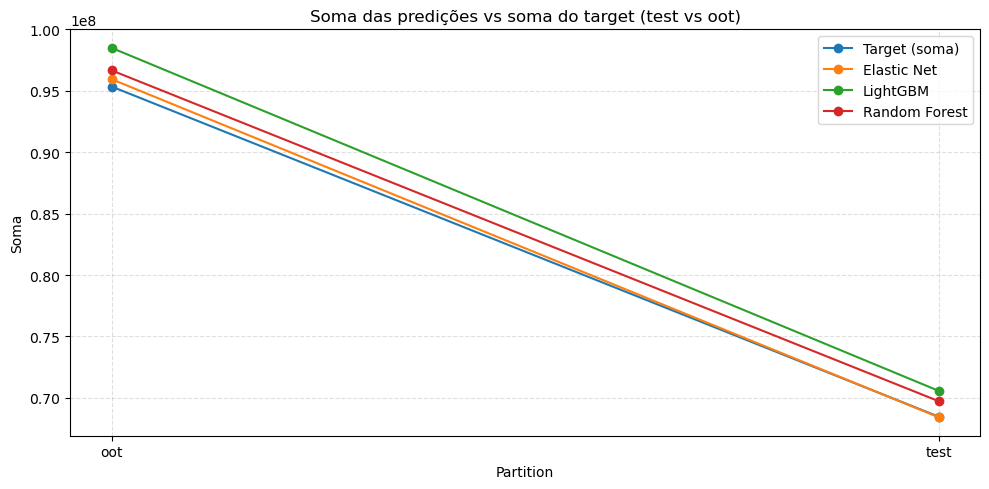

In [ ]:
# ============================================================
# 3) FECHAMENTO AGREGADO: soma(y) vs soma(ŷ) (test e oot)
# ============================================================

agg = (df_cmp.groupBy("partition")
    .agg(
        F.count("*").alias("n"),
        F.sum("target_win").alias("sum_y"),
        F.sum("pred_en").alias("sum_pred_en"),
        F.sum("pred_lgbm").alias("sum_pred_lgbm"),
        F.sum("pred_rf").alias("sum_pred_rf")
    )
    .withColumn("rel_err_en",   (F.col("sum_pred_en")   - F.col("sum_y")) / F.col("sum_y"))
    .withColumn("rel_err_lgbm", (F.col("sum_pred_lgbm") - F.col("sum_y")) / F.col("sum_y"))
    .withColumn("rel_err_rf",   (F.col("sum_pred_rf")   - F.col("sum_y")) / F.col("sum_y"))
    .orderBy("partition")
)

print("\n" + "="*90)
print("🧾 FECHAMENTO AGREGADO: soma predições vs soma target (e erro relativo)")
print("="*90)
agg.select(
    "partition","n",
    F.round("sum_y",2).alias("sum_y"),
    F.round("sum_pred_en",2).alias("sum_pred_en"),
    F.round("sum_pred_lgbm",2).alias("sum_pred_lgbm"),
    F.round("sum_pred_rf",2).alias("sum_pred_rf"),
    F.round("rel_err_en",4).alias("rel_err_en"),
    F.round("rel_err_lgbm",4).alias("rel_err_lgbm"),
    F.round("rel_err_rf",4).alias("rel_err_rf"),
).show(truncate=False)

# Plot das somas (2 linhas, leve)
pdf_agg = agg.toPandas()
plt.figure(figsize=(10,5))
plt.plot(pdf_agg["partition"], pdf_agg["sum_y"], marker="o", label="Target (soma)")
plt.plot(pdf_agg["partition"], pdf_agg["sum_pred_en"], marker="o", label="Elastic Net")
plt.plot(pdf_agg["partition"], pdf_agg["sum_pred_lgbm"], marker="o", label="LightGBM")
plt.plot(pdf_agg["partition"], pdf_agg["sum_pred_rf"], marker="o", label="Random Forest")
plt.title("Soma das predições vs soma do target (test vs oot)")
plt.xlabel("Partition"); plt.ylabel("Soma")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

- Menor Erro Relativo (OOT): Elastic Net, Random Forest, LightGBM;
- Menor Erro Relativo (Test): Elastic Net, Random Forest, LightGBM;

**Vencedor: Elastic Net.**

### 13.6.6. Calibracao por decil

In [ ]:
df_oot = df_cmp.filter(F.col("partition") == "oot")

def decile_calibration(df, pred_col, label):
    # Cria a janela ordenando pela coluna de predição passada como parâmetro
    w = Window.orderBy(F.col(pred_col))  # <-- aqui usa pred_col
    
    tmp = (df.withColumn("rn", F.row_number().over(w)))

    n = tmp.count()
    tmp = tmp.withColumn("decile", F.floor((F.col("rn")-1) / (F.lit(n)/F.lit(10))) + 1)
    tmp = tmp.withColumn("decile", F.when(F.col("decile")>10, 10).otherwise(F.col("decile")))

    out = (tmp
        .withColumn("err", F.col("target_win") - F.col(pred_col))  # <-- aqui também
        .withColumn("ae", F.abs("err"))
        .groupBy("decile")
        .agg(
            F.count("*").alias("n"),
            F.sum("target_win").alias("sum_y"),
            F.sum(pred_col).alias("sum_pred"),  # <-- e aqui
            F.mean("ae").alias("mae"),
            F.mean("target_win").alias("mean_y"),
            F.mean(pred_col).alias("mean_pred")  # <-- e aqui
        )
        .withColumn("Modelo", F.lit(label))
        .orderBy("decile")
    )
    return out

cal_en   = decile_calibration(df_oot, "pred_en",   "Elastic Net")
cal_lgbm = decile_calibration(df_oot, "pred_lgbm", "LightGBM (Tuned)")
cal_rf   = decile_calibration(df_oot, "pred_rf",   "Random Forest (Tuned)")

df_cal = cal_en.unionByName(cal_lgbm).unionByName(cal_rf).cache()

list_cal = [cal_en, cal_lgbm, cal_rf]

print("\n" + "="*90)
print("📈 CALIBRAÇÃO POR DECIL (OOT): soma(y) vs soma(ŷ) e MAE por decil")
print("="*90)
for df in list_cal:
    df.show(truncate=False)



📈 CALIBRAÇÃO POR DECIL (OOT): soma(y) vs soma(ŷ) e MAE por decil
+------+------+--------------------+--------------------+------------------+------------------+------------------+-----------+
|decile|n     |sum_y               |sum_pred            |mae               |mean_y            |mean_pred         |Modelo     |
+------+------+--------------------+--------------------+------------------+------------------+------------------+-----------+
|1     |185074|-9761604.579586446  |-9188399.322666442  |27.838144807401545|-52.74433242695596|-49.64716449996457|Elastic Net|
|2     |185073|4094673.1806230242  |4725561.764463908   |18.820043601490433|22.124638281235104|25.53350172344917 |Elastic Net|
|3     |185073|7036904.979092318   |7545851.085786953   |12.99490413154297 |38.022320809044636|40.77229571999672 |Elastic Net|
|4     |185073|8246268.4950592695  |8449272.012420775   |8.6782720250006   |44.5568424084511  |45.6537258942189  |Elastic Net|
|5     |185073|8754886.427995892   |9423164.4

- Melhor MAE nos decis centrais (3 e 4): LightGBM, Random Forest, Elastic Net;
- Melhor aderência em valores negativos (Decil 1): LightGBM, Elastic Net, Random Forest;
- Melhor consistência linear (Mean Y vs Mean $\hat{Y}$): LightGBM, Random Forest, Elastic Net;

**Vencedor: LightGBM.**

### 13.6.7. Top 5% erros

In [ ]:
def tail_metrics(df, pred_col, label, q=0.95):
    tmp = (df
        .select("target_win", F.col(pred_col).alias("pred"))
        .withColumn("residual", F.col("target_win") - F.col("pred"))
        .withColumn("abs_residual", F.abs("residual"))
    )
    thr = tmp.approxQuantile("abs_residual", [q], 0.001)[0]
    worst = tmp.filter(F.col("abs_residual") >= F.lit(thr))

    out = (worst
        .withColumn("ae", F.abs("residual"))
        .withColumn("se", F.col("residual")*F.col("residual"))
        .groupBy()
        .agg(
            F.count("*").alias("n_worst"),
            F.sqrt(F.mean("se")).alias("rmse_worst"),
            F.mean("ae").alias("mae_worst"),
            F.mean("residual").alias("bias_worst"),
            F.lit(thr).alias("thr_abs_residual")
        )
        .withColumn("Modelo", F.lit(label))
        .select("Modelo","n_worst","thr_abs_residual","rmse_worst","mae_worst","bias_worst")
    )
    return out

tail_en   = tail_metrics(df_oot, "pred_en",   "Elastic Net", q=0.95)
tail_lgbm = tail_metrics(df_oot, "pred_lgbm", "LightGBM (Tuned)", q=0.95)
tail_rf   = tail_metrics(df_oot, "pred_rf",   "Random Forest (Tuned)", q=0.95)

df_tail = tail_en.unionByName(tail_lgbm).unionByName(tail_rf)

print("\n" + "="*90)
print("🔥 CAUDA DE ERRO (OOT): métricas no Top 5% abs_residual")
print("="*90)
df_tail.select(
    "Modelo",
    "n_worst",
    F.round("thr_abs_residual",4).alias("thr_abs_residual"),
    F.round("rmse_worst",6).alias("RMSE worst"),
    F.round("mae_worst",6).alias("MAE worst"),
    F.round("bias_worst",6).alias("Bias worst (mean residual)")
).orderBy(F.col("RMSE worst").asc()).show(truncate=False)


🔥 CAUDA DE ERRO (OOT): métricas no Top 5% abs_residual
+---------------------+-------+----------------+----------+----------+--------------------------+
|Modelo               |n_worst|thr_abs_residual|RMSE worst|MAE worst |Bias worst (mean residual)|
+---------------------+-------+----------------+----------+----------+--------------------------+
|Random Forest (Tuned)|94317  |53.2389         |122.121025|117.423842|-64.702073                |
|LightGBM (Tuned)     |94350  |51.6017         |124.044288|119.031077|-64.016355                |
|Elastic Net          |94355  |71.937          |126.490609|123.741347|-69.722445                |
+---------------------+-------+----------------+----------+----------+--------------------------+



- Menor Threshold de Resíduo: LightGBM, Random Forest, Elastic Net;
- Melhor "Pior RMSE": Random Forest, LightGBM, Elastic Net;
- Melhor "Pior MAE": Random Forest, LightGBM, Elastic Net;
- Menor "Pior Viés": LightGBM, Random Forest, Elastic Net;

**Vencedor: Empate entre Random Forest e LightGBM.**

### 13.6.8. Scatter Plot: target vs. prediction

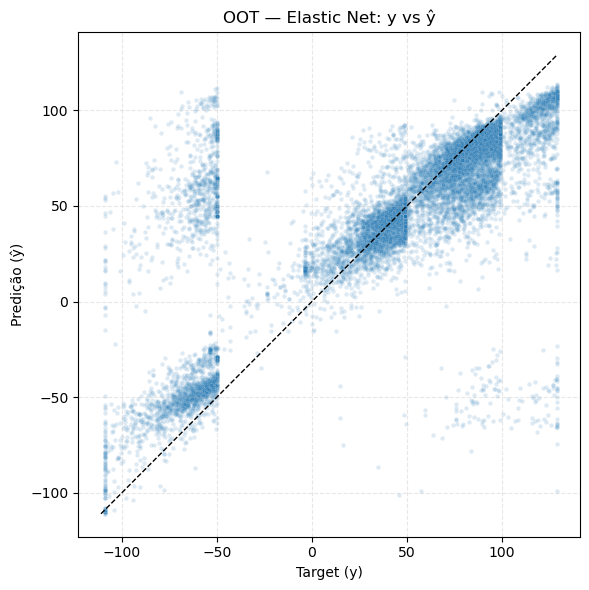

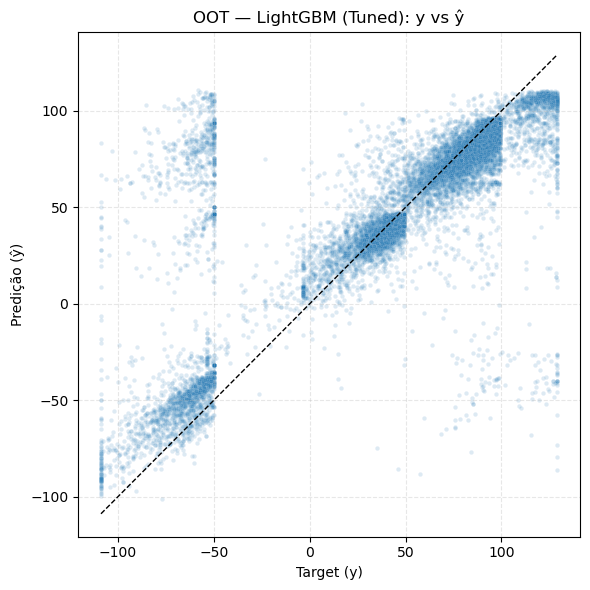

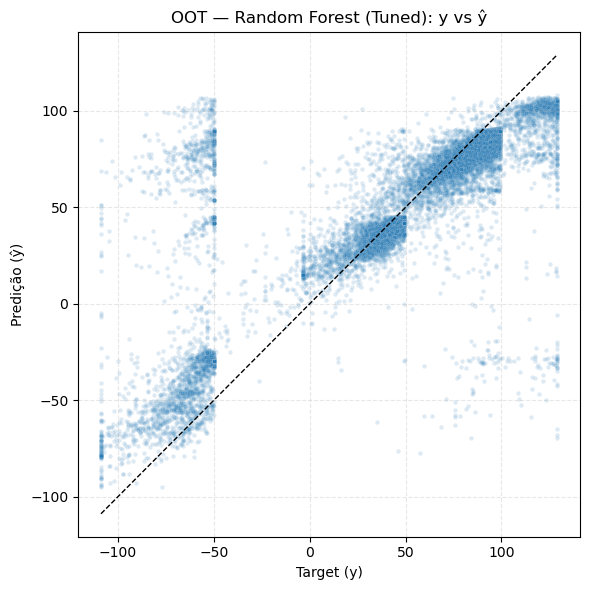

In [ ]:
# ============================================================
# 6) SCATTER: y vs yhat (OOT) — amostra igual pros 3 modelos
# ============================================================

# Amostragem única para os 3 (mesmas linhas)
pdf_sc = (df_oot
    .select("target_win","pred_en","pred_lgbm","pred_rf")
    .sample(False, 0.01, 42)  # ajuste: 0.005 se ficar pesado
    .toPandas()
)

def scatter_y_vs_yhat(pdf, pred_col, title):
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=pdf, x="target_win", y=pred_col, alpha=0.15, s=10)
    # linha y=x
    mn = min(pdf["target_win"].min(), pdf[pred_col].min())
    mx = max(pdf["target_win"].max(), pdf[pred_col].max())
    plt.plot([mn,mx],[mn,mx], linestyle="--", color="black", linewidth=1)
    plt.title(title)
    plt.xlabel("Target (y)")
    plt.ylabel("Predição (ŷ)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

scatter_y_vs_yhat(pdf_sc, "pred_en",   "OOT — Elastic Net: y vs ŷ")
scatter_y_vs_yhat(pdf_sc, "pred_lgbm", "OOT — LightGBM (Tuned): y vs ŷ")
scatter_y_vs_yhat(pdf_sc, "pred_rf",   "OOT — Random Forest (Tuned): y vs ŷ")

Visualizacoes extremamente parecidas. Os modelos sao bem similares entre si.

### 13.6.9. Escolha Final: LightGBM (Tuned)

Embora o Elastic Net apresente o melhor fechamento financeiro agregado (soma total), o LightGBM foi o vencedor absoluto na maioria das métricas avaliadas. Demonstrou ser o modelo mais estável temporalmente, com a melhor capacidade de distinguir perfis de clientes por decil e a maior precisão individual (MAE).